# County Permits

In [1]:
import os
import io
import requests
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import seaborn as sns
sns.set_style(style='darkgrid')
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
%matplotlib inline


## Overview

In [3]:
#cp = pd.read_csv('https://data.montgomerycountymd.gov/resource/i26v-w6bd.csv')
cp = pd.read_csv('Commercial_Permits (4).csv')
#The new updated link still only loads up a thousand rows


In [4]:
cp.tail()

,Permit Number,Status,Street Number,Pre-direction,Street Name,Street Suffix,Post-direction,City,State,ZIP code,Added Date,Issue Date,Final Date,Building Area,Declared Valuation,Description,Application Type,Work Type,Use Code,Location
28801,744532,Finaled,9704,NaN,MEDICAL CENTER,DR,NaN,ROCKVILLE,MD,20850.0,02/12/2016,03/14/2016,03/21/2017,27000.0,1162792.0,Interior Alterations : including systems Furni...,COMMERCIAL BUILDING,ALTER,BUSINESS BUILDING,"9704 MEDICAL CENTER DR\nROCKVILLE, MD 20850\n(..."
28802,745364,Finaled,4800,NaN,HAMPDEN,LN,NaN,BETHESDA,MD,20814.0,02/22/2016,04/29/2016,08/18/2016,11027.0,527683.0,Partial renovation of the 3rd Floor Revision 0...,COMMERCIAL BUILDING,ALTER,BUSINESS BUILDING,"4800 HAMPDEN LN\nBETHESDA, MD 20814\n(38.98271..."
28803,745969,Finaled,4806,NaN,MONTGOMERY,LN,NaN,BETHESDA,MD,20814.0,02/25/2016,03/04/2016,05/24/2016,700.0,8000.0,Restore and repair -Girder Truss,COMMERCIAL BUILDING,RESTORE AND / OR REPAIR,TOWNHOUSE,"4806 MONTGOMERY LN\nBETHESDA, MD 20814\n(38.98..."
28804,744012,Open,12510,NaN,PENNYFIELD LOCK,RD,NaN,POTOMAC,MD,20854.0,02/08/2016,NaN,NaN,1.0,50825.0,2 TIERED 18 FT RETAINING WALL IN COMMON AREA,COMMERCIAL BUILDING,CONSTRUCT,RETAINING WALL,"12510 PENNYFIELD LOCK RD\nPOTOMAC, MD 20854\n(..."
28805,744731,Issued,2219,NaN,BEL PRE,RD,NaN,SILVER SPRING,MD,20906.0,02/16/2016,07/01/2016,NaN,36363.0,4300000.0,"Customer Wants To Use ePlans,Construction of a...",COMMERCIAL BUILDING,CONSTRUCT,COMMERCIAL MISCELLANEOUS STRUC,"2219 BEL PRE RD\nSILVER SPRING, MD 20906\n(39...."


In [5]:
cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28806 entries, 0 to 28805
Data columns (total 20 columns):
Permit Number         28806 non-null int64
Status                28806 non-null object
Street Number         27655 non-null object
Pre-direction         749 non-null object
Street Name           27677 non-null object
Street Suffix         27626 non-null object
Post-direction        63 non-null object
City                  27657 non-null object
State                 27652 non-null object
ZIP code              27611 non-null float64
Added Date            28806 non-null object
Issue Date            27072 non-null object
Final Date            15691 non-null object
Building Area         27133 non-null float64
Declared Valuation    27946 non-null float64
Description           26652 non-null object
Application Type      28806 non-null object
Work Type             28802 non-null object
Use Code              28806 non-null object
Location              27677 non-null object
dtypes: float6

In [6]:
cp.describe().T

,count,mean,std,min,25%,50%,75%,max
Permit Number,28806.0,606784.408387,5.887310e+06,208677.0,405144.0,575960.5,747323.25,9.992111e+08
ZIP code,27611.0,20862.615588,2.360910e+02,0.0,20841.0,20871.0,20902.00,2.177100e+04
Building Area,27133.0,10601.539407,4.358353e+04,0.0,350.0,1636.0,4320.00,1.600000e+06
Declared Valuation,27946.0,757027.594376,8.160478e+06,0.0,18000.0,60000.0,200000.00,1.129634e+09


In [7]:
cp.head()

,Permit Number,Status,Street Number,Pre-direction,Street Name,Street Suffix,Post-direction,City,State,ZIP code,Added Date,Issue Date,Final Date,Building Area,Declared Valuation,Description,Application Type,Work Type,Use Code,Location
0,891330,Open,5471,NaN,WISCONSIN,AVE,NaN,CHEVY CHASE,MD,20815.0,09/30/2019,NaN,NaN,100.0,30000.0,RESTORE &amp; REPAIR STRUCTURAL BEAM,COMMERCIAL BUILDING,RESTORE AND / OR REPAIR,BUSINESS BUILDING,"5471 WISCONSIN AVE\nCHEVY CHASE, MD 20815\n(38..."
1,891377,Open,312,NaN,BALTUSROL,DR,NaN,GERMANTOWN,MD,20874.0,09/30/2019,NaN,NaN,300.0,25000.0,"Customer Wants To Use ePlans,brick on CMU wall...",COMMERCIAL BUILDING,CONSTRUCT,COMMERCIAL MISCELLANEOUS STRUC,"312 BALTUSROL DR\nGERMANTOWN, MD 20874"
2,788131,Issued,12100,NaN,PLUM ORCHARD,DR,NaN,SILVER SPRING,MD,20904.0,01/31/2017,04/11/2017,NaN,294813.0,73000000.0,Revision 3 - Vertical expansion const. on the ...,COMMERCIAL BUILDING,CONSTRUCT,HOSPITAL,"12100 PLUM ORCHARD DR\nSILVER SPRING, MD 20904..."
3,873775,Issued,18320,NaN,CONTOUR,RD,NaN,MONTGOMERY VILLAGE,MD,20886.0,04/29/2019,06/28/2019,NaN,920.0,79000.0,CHANGE OF USE: Business to RESTAURANT,COMMERCIAL BUILDING,COMMERCIAL CHANGE OF USE,RESTAURANT,"18320 CONTOUR RD\nMONTGOMERY VILLAGE, MD 20886..."
4,863967,Finaled,11545,NaN,ROCKVILLE,PIKE,NaN,ROCKVILLE,MD,20852.0,01/21/2019,05/31/2019,08/16/2019,30960.0,1937700.0,"Revision ,01 - Modify construction details. N...",COMMERCIAL BUILDING,ALTER,BUSINESS BUILDING,"11545 ROCKVILLE PIKE\nROCKVILLE, MD 20852\n(39..."


In [8]:
cp['Permit Number'].nunique()

28806

# Wrangling

In [9]:
cpr = cp.rename({"Permit Number":"P_num", "Street Number":"St_number", "Pre-direction": "Pre_d", "Street Name":"St_name", "Street Number":"St_num",
                 "Street Suffix":"St_suf", "Post-direction":"Post_d","ZIP code":"Zip", "Added Date":"A_date",
                 "Issue Date":"I_date","Final Date":"F_date", "Building Area":"Building_area", "Building Area":"Building_area", 
                 "Declared Valuation":"Decl_v", "Description":"Desc", "Application Type":"A_type", "Work Type":"W_type", "Use Code":"U_code"}, axis='columns')

In [10]:
#sorting Values by "P_num"
cp1 = cpr.sort_values(["P_num"])
#change index to match P_num
cp2 = cp1.reset_index(drop=True)
cp2.shape

(28806, 20)

In [11]:
#Droping Application type and state since all are commerical in this set
cp1[(cp1['A_type'] != 'COMMERCIAL BUILDING')]
cp2.drop('A_type', axis=1, inplace=True)
cp2.drop('State', axis=1, inplace=True)

In [12]:
#Changing dates to DateTime
cp2.A_date = pd.to_datetime(cp2.A_date)
cp2.I_date = pd.to_datetime(cp2.I_date)
cp2.F_date = pd.to_datetime(cp2.F_date)
type(cp2.F_date[1])

pandas._libs.tslibs.timestamps.Timestamp

In [13]:
#changeing Zip from a float to a string
cp2.Zip = cp2.Zip.fillna(-1)
cp2.Zip = cp2.Zip.astype(int)
cp2.Zip = cp2.Zip.astype(str)
cp2.Zip = cp2.Zip.replace('-1', "Na")
type(cp2.Zip[1])
#what was wrong with this

str

In [14]:
cp2.head()

,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,Location
0,208677,Finaled,19850,NaN,CENTURY,BLVD,NaN,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-10,42600.0,1000000.0,NaN,CONSTRUCT,MULTI-FAMILY DWELLING,"19850 CENTURY BLVD\nGERMANTOWN, MD 20874\n(39...."
1,208678,Finaled,12901,NaN,PINNACLE,DR,NaN,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-11,42600.0,1000000.0,NaN,CONSTRUCT,MULTI-FAMILY DWELLING,"12901 PINNACLE DR\nGERMANTOWN, MD 20874\n(39.1..."
2,208679,Finaled,12903,NaN,PINNACLE,DR,NaN,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-12,42600.0,1000000.0,NaN,CONSTRUCT,MULTI-FAMILY DWELLING,"12903 PINNACLE DR\nGERMANTOWN, MD 20874\n(39.1..."
3,208689,Finaled,12907,NaN,PINNACLE,DR,NaN,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-31,63300.0,1500000.0,NaN,CONSTRUCT,MULTI-FAMILY DWELLING,"12907 PINNACLE DR\nGERMANTOWN, MD 20874\n(39.1..."
4,208690,Finaled,12909,NaN,PINNACLE,DR,NaN,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-29,63300.0,1500000.0,NaN,CONSTRUCT,MULTI-FAMILY DWELLING,"12909 PINNACLE DR\nGERMANTOWN, MD 20874\n(39.1..."


In [15]:
cp2.shape

(28806, 18)

Dealing with missing Data

In [16]:
cp2.isnull().values.sum()

82078

In [17]:
#Calculating the percentage of missing data
missing_data = cp2.isnull().sum()
missing_data / len(cp2) * 100
#find out based on year

P_num             0.000000
Status            0.000000
St_num            3.995695
Pre_d            97.399847
St_name           3.919322
St_suf            4.096369
Post_d           99.781296
City              3.988752
Zip               0.000000
A_date            0.000000
I_date            6.019579
F_date           45.528709
Building_area     5.807818
Decl_v            2.985489
Desc              7.477609
W_type            0.013886
U_code            0.000000
Location          3.919322
dtype: float64

In [18]:
#Filling in Na's for post and pre directions
cp3 = cp2.copy()
cp2.loc[cp2.Post_d.notnull()]
cp3.Post_d.fillna("N/A", inplace=True)
cp2.loc[cp2.Pre_d.notnull()]
cp3.Pre_d.fillna("N/A",inplace =True)

In [19]:
cp1.Desc.isna().sum()

2154

In [20]:
cp3.Desc.fillna("N/A",inplace =True)

In [21]:
cp3.isnull().values.sum()

23124

Dealing with Finaled date
Seeing that the status and finalled are the same

In [22]:
cp3.F_date.notnull().sum()

15691

In [23]:
cp3.Status.value_counts()


Finaled      15600
Issued       10712
Open          1667
Stop Work      827
Name: Status, dtype: int64

Here I am checking that the Status column and the Issue and Added Dates match. 

In [24]:
#Decrepancey of 91
cp3.loc[(cp3.Status == 'Stop Work' ) & cp3.F_date.notnull()]
# contains 84 non-null, so still need 7
cp3.loc[(cp3.Status == 'Issued' ) & cp3.F_date.notnull()]
# there we go so 7 which in total accounts for the decrpeancy of 91
cp3.loc[(cp3.Status == 'Open' ) & cp3.F_date.notnull()]
#all are null

,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,Location


In [25]:
cp3.F_date.fillna("N/A",inplace =True)

In [25]:
missing_data3 = cp3.isnull().sum()
missing_data3

P_num                0
Status               0
St_num            1151
Pre_d                0
St_name           1129
St_suf            1180
Post_d               0
City              1149
Zip                  0
A_date               0
I_date            1734
F_date           13115
Building_area     1673
Decl_v             860
Desc                 0
W_type               4
U_code               0
Location          1129
dtype: int64

So before I deal with the rest of the NA's I am going to drop all the faulty location data

In [26]:
Naloc = cp3[cp3.Location.isnull() & cp3.St_num.isnull() & 
            cp3.City.isnull() &  cp3.Zip.isnull()]
Naloc.describe()

,P_num,Building_area,Decl_v
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [27]:
D2 = cp3.copy()
D2.dropna(subset=[ 'Location', 'Zip', 'City', 'St_num', 'St_name' ], inplace=True)
D2.shape

(27636, 18)

In [29]:
missing_data4 = D2.isnull().sum()
missing_data4

P_num                0
Status               0
St_num               0
Pre_d                0
St_name              0
St_suf              48
Post_d               0
City                 0
Zip                  0
A_date               0
I_date            1532
F_date           12544
Building_area     1603
Decl_v             822
Desc                 0
W_type               3
U_code               0
Location             0
dtype: int64

Dealing with the remaining Values 

In [30]:
#Declared Value
D2.Decl_v.value_counts
D2.Decl_v = D2.Decl_v.fillna(0)

In [31]:
D2.Building_area.value_counts()
D2.Building_area = D2.Building_area.fillna(0)

In [32]:
# manage with editing
D2.loc[(D2.St_suf.isnull())]


,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,Location
8480,446385,Open,7500,N/A,WOODMONT,NaN,N/A,BETHESDA,20814,2007-03-01,NaT,NaT,0.000,0.0,Code Modification Only IBC: Remove the dividi...,ALTER,MULTI-FAMILY DWELLING,"7500 WOODMONT\nBETHESDA, MD 20814\n(38.984252,..."
9825,479721,Finaled,12500,N/A,PARK POTOMAC,NaN,N/A,POTOMAC,20854,2008-03-11,2008-09-19,2009-05-13,480.000,200000.0,Entrance to Condos and Canopy Replacement,ADD,MULTI-FAMILY DWELLING,"12500 PARK POTOMAC\nPOTOMAC, MD 20854\n(39.060..."
10775,503908,Issued,12500,N/A,PARK POTOMAC,NaN,N/A,POTOMAC,20854,2009-01-22,2009-03-09,NaT,480.000,15000.0,To provide conduit and electrical panels for 3...,ALTER,MERCANTILE BUILDING,"12500 PARK POTOMAC\nPOTOMAC, MD 20854\n(39.060..."
11445,518289,Issued,12500,N/A,PARK POTOMAC,NaN,N/A,POTOMAC,20854,2009-08-06,2009-08-20,NaT,40.000,1800.0,Unit #907 N\nCoversion of existing bedroom and...,ALTER,MULTI-FAMILY DWELLING,"12500 PARK POTOMAC\nPOTOMAC, MD 20854\n(39.060..."
11626,522605,Issued,21040,N/A,HENDERSON CORNER,NaN,N/A,GERMANTOWN,20876,2009-10-02,2010-08-09,NaT,6622.000,750000.0,Construct new 7-Eleven convenience store with ...,CONSTRUCT,MERCANTILE BUILDING,"21040 HENDERSON CORNER\nGERMANTOWN, MD 20876"
12038,529231,Finaled,14201,N/A,GEORGIA AVE,NaN,N/A,SILVER SPRING,20906,2010-01-13,2010-04-26,2010-07-19,3500.000,15000.0,FIRE REPAIR BACK TO ORIGINAL CONDITION ONLY - ...,RESTORE AND / OR REPAIR,MULTI-FAMILY DWELLING,"14201 GEORGIA AVE\nSILVER SPRING, MD 20906\n(3..."
12389,536136,Finaled,14201,N/A,GEORGIA AVE,NaN,N/A,SILVER SPRING,20906,2010-04-26,2010-05-20,2010-12-02,12305.000,150000.0,FIRE REPAIR BACK TO ORIGINAL CONDITION ONLY - ...,RESTORE AND / OR REPAIR,MULTI-FAMILY DWELLING,"14201 GEORGIA AVE\nSILVER SPRING, MD 20906\n(3..."
12394,536331,Issued,21040,N/A,HENDERSON CORNER,NaN,N/A,GERMANTOWN,20876,2010-04-27,2010-08-03,NaT,50.000,3000.0,monument sign,ADD,COMMERCIAL MISCELLANEOUS STRUC,"21040 HENDERSON CORNER\nGERMANTOWN, MD 20876"
12476,537804,Finaled,7500,N/A,WOODMONT,NaN,N/A,BETHESDA,20814,2010-05-13,2010-06-02,2010-06-18,81.000,0.0,removing fireplace in 3 units,ALTER,MULTI-FAMILY DWELLING,"7500 WOODMONT\nBETHESDA, MD 20814\n(38.984252,..."
12971,549782,Issued,21040,N/A,HENDERSON CORNER,NaN,N/A,GERMANTOWN,20876,2010-09-22,2010-10-05,NaT,2000.000,26000.0,Construct Retaining Wall\n**Intermediate Track...,CONSTRUCT,RETAINING WALL,"21040 HENDERSON CORNER\nGERMANTOWN, MD 20876"


In [33]:
D2.dropna(subset=[ 'W_type'], inplace=True)
D2.shape

(27633, 18)

In [34]:
print("Old data frame length:", len(cp), "\nNew data frame length:",  
       len(D2), "\nNumber of rows with at least 1 NA value: ", 
       (len(cp)-len(D2))) 

Old data frame length: 28806 
New data frame length: 27633 
Number of rows with at least 1 NA value:  1173


In [35]:
cp1["Null Column"]= None
print(cp1.columns.values, "\n", cp1.columns.values)

['P_num' 'Status' 'St_num' 'Pre_d' 'St_name' 'St_suf' 'Post_d' 'City'
 'State' 'Zip' 'A_date' 'I_date' 'F_date' 'Building_area' 'Decl_v' 'Desc'
 'A_type' 'W_type' 'U_code' 'Location' 'Null Column'] 
 ['P_num' 'Status' 'St_num' 'Pre_d' 'St_name' 'St_suf' 'Post_d' 'City'
 'State' 'Zip' 'A_date' 'I_date' 'F_date' 'Building_area' 'Decl_v' 'Desc'
 'A_type' 'W_type' 'U_code' 'Location' 'Null Column']


In counclusion much has already been done to remove the 1600 rows with missing data.
Now to filter and see how many of the same type

Dennis said some of the permit locations are off how to fix that each permit should line up with its zip code

First I am going to see how many permits are in each city

In [36]:
D2.City.value_counts()

SILVER SPRING         6913
BETHESDA              4471
ROCKVILLE             4141
GERMANTOWN            2807
CLARKSBURG            1930
GAITHERSBURG          1347
CHEVY CHASE           1237
POTOMAC               1042
OLNEY                  554
KENSINGTON             536
TAKOMA PARK            532
MONTGOMERY VILLAGE     365
BOYDS                  342
DAMASCUS               313
BURTONSVILLE           299
POOLESVILLE            137
SANDY SPRING           130
DICKERSON              123
BROOKEVILLE             87
WHEATON                 73
NORTH BETHESDA          41
CABIN JOHN              37
ASHTON                  35
DERWOOD                 25
SPENCERVILLE            19
DARNESTOWN              18
BEALLSVILLE             17
MOUNT AIRY              15
LAYTONSVILLE            10
GARRETT PARK             9
GLEN ECHO                8
WASHINGTON GROVE         6
HIGHLAND                 4
NORTH POTOMAC            3
ASPEN HILL               2
BELTSVILLE               2
BRINKLOW                 1
S

In [37]:
D2.City.replace(['SILVERSPRING'], ['SILVER SPRING'], inplace=True)


So Dennis said that some of the permit data was not properly matched to its city. 
I found a great package that is called uszipcode. The package retrives data from zip code information or location data.

In [38]:
# Testing out package
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)
zipcode = search.by_zipcode("20902")
zipcode.values()

['20902',
 'Standard',
 'Silver Spring',
 'Silver Spring, MD',
 ['Silver Spring', 'Wheaton'],
 'Montgomery County',
 'MD',
 39.04,
 -77.04,
 'Eastern',
 3.0,
 ['240', '301'],
 48841,
 6443.0,
 7.58,
 0.03,
 17073,
 16271,
 355500,
 76646,
 -77.082046,
 -77.006729,
 39.066505,
 39.015571]

In [39]:
#Creating list to store new values based off data's Zip column
new_location = []
search = SearchEngine(simple_zipcode=True)
# Iterating through each row 
for index,row in D2.iterrows():
    current_city = row['Zip']
    zipcode = search.by_zipcode(current_city)
    new_location.append(zipcode.values()[2])

In [40]:
# Creating new column in data set for the data retrived via the package
D2['NewCity'] = new_location

In [41]:
[i*2 for i in D2.P_num]

[417354,
 417356,
 417358,
 417378,
 417380,
 417382,
 417384,
 417432,
 417478,
 417544,
 417546,
 417564,
 417566,
 417852,
 417858,
 417902,
 417904,
 417908,
 418104,
 418106,
 418154,
 418170,
 418208,
 418546,
 418550,
 418556,
 418866,
 418984,
 418986,
 418994,
 418996,
 419008,
 419198,
 419298,
 419320,
 419346,
 419372,
 419556,
 419750,
 419820,
 419822,
 419830,
 419838,
 419840,
 419888,
 419958,
 419960,
 419978,
 420054,
 420134,
 420162,
 420250,
 420340,
 420368,
 420598,
 420646,
 420656,
 420696,
 420702,
 420706,
 420710,
 420716,
 420740,
 420816,
 420850,
 420922,
 420982,
 420994,
 421074,
 421076,
 421192,
 421244,
 421276,
 421288,
 421296,
 421384,
 421446,
 421472,
 421478,
 421504,
 421538,
 421736,
 421740,
 421742,
 421744,
 421746,
 421748,
 421844,
 421846,
 421850,
 421852,
 421856,
 421858,
 421860,
 421862,
 421864,
 421866,
 421868,
 421870,
 421872,
 421874,
 421906,
 421908,
 421910,
 421914,
 421916,
 421918,
 421920,
 421922,
 421924,
 421926,
 

In [42]:
# Iterating throught each row to see the difference between the data's city info and the info the package retrived
for index,row in D2.iterrows():
    if row['NewCity'] != None:
        old = row['City'].lower()
        new = row['NewCity'].lower()
        if old != new:
            print(old,new)

darnestown gaithersburg
silver spring takoma park
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
silver spring takoma park
rockville derwood
silver spring takoma park
bethesda potomac
rockville derwood
rockville derwood
rockville derwood
wheaton silver spring
rockville derwood
laytonsville gaithersburg
rockville derwood
wheaton silver spring
wheaton silver spring
darnestown gaithersburg
darnestown gaithersburg
darnestown gaithersburg
rockville derwood
rockville derwood
rockville derwood
rockville derwood
wheaton silver spring
silver spring takoma park
clarksburg damascus
rockville derwood
laytonsville gaithersburg
rockville derwood
rockville derwood
rockville derwood
rockville gaithersburg
rockville derwood
rockville derwood
rockville derwood
rockville derwood
clarksburg damascus
clarksburg damascus
rockville potomac
ro

rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville bethesda
darnestown gaithersburg
gaithersburg montgomery village
wheaton silver spring
silver spring takoma park
rockville potomac
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
north bethesda rockville
rockville derwood
rockville derwood
rockville derwood
silver spring takoma park
wheaton silver spring
rockville derwood
chevy chase bethesda
bethesda chevy chase
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
bethesda chevy chase
north potomac gaithersburg
rockville derwood
wheaton silver spring
rockville derwood
gaithersburg montgomery village
wheaton silver spring
wheaton silver spring
silver spring takoma park
rockville derwood
rockville derwood
gaithersburg montgomery village
rockville derwood


rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville bethesda
rockville derwood
rockville bethesda
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
gaithersburg montgomery village
wheaton silver spring
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
aspen hill silver spring
rockville derwood
wheaton silver spring
rockville derwood
rockville derwood
rockville bethesda
rockville bethesda
rockville derwood
wheaton silver spring
rockville derwood
rockville derwood
rockville derwood
wheaton silver spring
darnestown gaithersburg
rockville bethesda
rockville bethesda
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwood
rockville derwo

In [43]:
from IPython.display import display
display(D2.NewCity.value_counts())
display(D2.City.value_counts())

Silver Spring         6954
Bethesda              4513
Rockville             3471
Germantown            2802
Clarksburg            1916
Gaithersburg          1355
Chevy Chase           1229
Potomac               1069
Derwood                661
Takoma Park            563
Olney                  547
Kensington             524
Montgomery Village     388
Boyds                  343
Damascus               321
Burtonsville           301
Poolesville            136
Sandy Spring           132
Dickerson              123
Brookeville             85
Cabin John              37
Ashton                  36
Spencerville            18
Beallsville             16
Mount Airy              15
Garrett Park             9
Glen Echo                8
Highland                 4
Beltsville               3
Washington Grove         2
Name: NewCity, dtype: int64

SILVER SPRING         6914
BETHESDA              4471
ROCKVILLE             4141
GERMANTOWN            2807
CLARKSBURG            1930
GAITHERSBURG          1347
CHEVY CHASE           1237
POTOMAC               1042
OLNEY                  554
KENSINGTON             536
TAKOMA PARK            532
MONTGOMERY VILLAGE     365
BOYDS                  342
DAMASCUS               313
BURTONSVILLE           299
POOLESVILLE            137
SANDY SPRING           130
DICKERSON              123
BROOKEVILLE             87
WHEATON                 73
NORTH BETHESDA          41
CABIN JOHN              37
ASHTON                  35
DERWOOD                 25
SPENCERVILLE            19
DARNESTOWN              18
BEALLSVILLE             17
MOUNT AIRY              15
LAYTONSVILLE            10
GARRETT PARK             9
GLEN ECHO                8
WASHINGTON GROVE         6
HIGHLAND                 4
NORTH POTOMAC            3
ASPEN HILL               2
BELTSVILLE               2
BRINKLOW                 1
D

          New City        Old City
* Silver Spring         6954     * SILVER SPRING         6913    
* Bethesda              4513     * BETHESDA              4471
* Rockville             3471     * ROCKVILLE             4141
* Germantown            2803     * GERMANTOWN            2808
- Clarksburg            1916     * CLARKSBURG            1930
* Gaithersburg          1356     * GAITHERSBURG          1348
* Chevy Chase           1229     * CHEVY CHASE           1237
- Potomac               1070     * POTOMAC               1043

So the discrepency is not so dramatic. The change in number mostly comes from Rockville losing permits to Deerwood, which had almost no permits before.

So now to deal with the the location column in the data frame. The "location" column appears to be compiled from the all of the location data present in the data set, such as address street number ect.
* To make usable Longitude and Latitude I split the location string twice.
* Then I made new columns for the address and and LnL data

In [44]:
E2 = D2.Location.str.split("(", n =1, expand = True)
# making separate logitude/ladditude column from new data frame 
D2["Address"]= E2[0] 
  
# making separate Address column from new data frame 
D2["LL"]= E2[1] 
  
# Dropping old Name columns 
D2.drop(columns =["Location"], inplace = True) 
# adding pertheses back in
# df display 
D2 

,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,NewCity,Address,LL
0,208677,Finaled,19850,N/A,CENTURY,BLVD,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-10,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"19850 CENTURY BLVD\nGERMANTOWN, MD 20874\n","39.181866, -77.26558)"
1,208678,Finaled,12901,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-11,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12901 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182081, -77.265196)"
2,208679,Finaled,12903,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-12,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12903 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182361, -77.265512)"
3,208689,Finaled,12907,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-31,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12907 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182922, -77.266143)"
4,208690,Finaled,12909,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-29,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12909 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183215, -77.266444)"
5,208691,Finaled,12925,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-25,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12925 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183411, -77.266188)"
6,208692,Issued,12935,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,NaT,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12935 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.18353, -77.265984)"
7,208716,Finaled,16507,S,FREDERICK,AVE,N/A,GAITHERSBURG,20877,2000-01-03,2000-01-03,2000-01-19,3000.0,10000.00,N/A,ALTER,BUSINESS BUILDING,Gaithersburg,"16507 FREDERICK AVE\nGAITHERSBURG, MD 20877\n","39.127932, -77.18505)"
8,208739,Finaled,8600,N/A,OLD GEORGETOWN,RD,N/A,BETHESDA,20817,2000-01-04,2000-01-27,2000-10-31,10350.0,110000.00,"the applicant call on Wednesday, January 12, 2...",ALTER,INSTITUTIONAL BUILDING,Bethesda,"8600 OLD GEORGETOWN RD\nBETHESDA, MD 20817\n","38.997251, -77.10922)"
9,208772,Finaled,12955,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-04,2000-12-14,2001-12-21,36400.0,750000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12955 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.18377, -77.265575)"


In [45]:
E2 = D2.LL.str.split(",", n =1, expand = True)
# making separate latitude column from new data frame 
D2["Lat"]= E2[0] 
  
# making separate logitude column from new data frame 
D2["Lon"]= E2[1] 

D2["Lat"]= D2.Lat.str.strip('(') 
D2["Lon"]= D2.Lon.str.strip(')') 

In [46]:
D2.LL.isna().value_counts()
# six percent

False    25769
True      1864
Name: LL, dtype: int64

In [47]:
D2.Lon.isna().value_counts()
D2.Lat.isna().value_counts()

False    25769
True      1864
Name: Lat, dtype: int64

In [48]:
#Make some sort of range
D2.Decl_v.value_counts()

0.00           928
25000.00       861
20000.00       831
10000.00       830
15000.00       785
50000.00       735
100000.00      683
30000.00       590
200000.00      550
5000.00        515
150000.00      491
80000.00       476
1.00           419
40000.00       385
60000.00       385
250000.00      318
300000.00      296
125000.00      286
75000.00       281
48000.00       281
35000.00       249
120000.00      221
45000.00       209
12000.00       190
2000.00        183
500000.00      174
400000.00      169
6000.00        161
3000.00        158
175000.00      153
95000.00       147
350000.00      145
8000.00        145
1000.00        145
70000.00       139
65000.00       137
600000.00      136
1000000.00     126
140000.00      120
85000.00       120
90000.00       119
1500000.00     113
55000.00       110
4000.00        108
27000.00       108
7500.00        107
1500.00        102
18000.00       101
180000.00       96
2000000.00      94
28000.00        92
32000.00        92
110000.00   

Make buckets to put valuation of buildings for example 1000 - 10000, 10000 - 50000, 50000- 100000, 10000
0.0	20841.0	20871.0	20902.00	2.177100e+04

In [49]:
Abins = [ 1.0 , 1000.0, 5000.0, 10000.0, 20000.0, 21000.0, 50000.0, 160000.0 ]
Agroup_names = [ '1sq.ft-1000sq.ft','1000sq.ft-5000sq.ft', '5000sq.ft-10000sq.ft', '10000sq.ft-20000sq.ft',
            '20000sq.ft-21000sq.ft','21000sq.ft-50000sq.ft','50000sq.ft-160000sq.ft' ]

In [50]:
D2['Area'] = pd.cut(D2['Building_area'], Abins, labels=Agroup_names)
D2['Area'].value_counts()

1000sq.ft-5000sq.ft       10744
1sq.ft-1000sq.ft           7429
5000sq.ft-10000sq.ft       2014
10000sq.ft-20000sq.ft      1600
21000sq.ft-50000sq.ft      1151
50000sq.ft-160000sq.ft      853
20000sq.ft-21000sq.ft        77
Name: Area, dtype: int64

In [51]:
bins = [1000.0,10000.0, 18000.0, 60000.0, 200000.0, 1000000.0, 5000000.0,
10000000.0, 20000000.0, 50000000.0, 100000000.0, 200000000.0]
group_names = [ '1k-10k', '10k-18k', '18k-60k', '60k-200k', '200k-1m',
   '1m-5m', '5m-10m', '10m-20m', '20m-50m', '50m-100M', '100m- 2b' ]

In [52]:
D2['Value'] = pd.cut(D2['Decl_v'], bins, labels=group_names)
D2['Value'].value_counts()
# there is only one permit with a value of over 1 billion dollars

60k-200k    7039
18k-60k     6828
200k-1m     4546
1k-10k      3623
10k-18k     1729
1m-5m       1450
5m-10m       268
10m-20m      181
20m-50m      157
50m-100M      42
100m- 2b       7
Name: Value, dtype: int64

In [53]:
type(cp2.Location[1])
type(cp2.St_num[1])

str

In [54]:
open_permits = D2.loc[(D2.Status == 'Open')]
open_permits.to_csv('open')

In [55]:
#filtering by year slices
Y_2000 = D2[(D2['A_date'] > '01/01/2000') & (D2['A_date'] < '01/01/2001')]
Y_2001 = D2[(D2['A_date'] > '01/01/2001') & (D2['A_date'] < '01/01/2002')]
Y_2002 = D2[(D2['A_date'] > '01/01/2002') & (D2['A_date'] < '01/01/2003')]
Y_2003 = D2[(D2['A_date'] > '01/01/2003') & (D2['A_date'] < '01/01/2004')]
Y_2004 = D2[(D2['A_date'] > '01/01/2004') & (D2['A_date'] < '01/01/2005')]
Y_2005 = D2[(D2['A_date'] > '01/01/2005') & (D2['A_date'] < '01/01/2006')]
Y_2006 = D2[(D2['A_date'] > '01/01/2006') & (D2['A_date'] < '01/01/2007')]
Y_2007 = D2[(D2['A_date'] > '01/01/2007') & (D2['A_date'] < '01/01/2008')]
Y_2008 = D2[(D2['A_date'] > '01/01/2008') & (D2['A_date'] < '01/01/2009')]
Y_2009 = D2[(D2['A_date'] > '01/01/2009') & (D2['A_date'] < '01/01/2010')]
Y_2010 = D2[(D2['A_date'] > '01/01/2010') & (D2['A_date'] < '01/01/2011')]
Y_2011 = D2[(D2['A_date'] > '01/01/2011') & (D2['A_date'] < '01/01/2012')]
Y_2012 = D2[(D2['A_date'] > '01/01/2012') & (D2['A_date'] < '01/01/2013')]
Y_2013 = D2[(D2['A_date'] > '01/01/2013') & (D2['A_date'] < '01/01/2014')]
Y_2014 = D2[(D2['A_date'] > '01/01/2014') & (D2['A_date'] < '01/01/2015')]
Y_2015 = D2[(D2['A_date'] > '01/01/2015') & (D2['A_date'] < '01/01/2016')]
Y_2016 = D2[(D2['A_date'] > '01/01/2016') & (D2['A_date'] < '01/01/2017')]
Y_2017 = D2[(D2['A_date'] > '01/01/2017') & (D2['A_date'] < '01/01/2018')]
Y_2018 = D2[(D2['A_date'] > '01/01/2018') & (D2['A_date'] < '01/01/2019')]
Y_2019 = D2[(D2['A_date'] > '01/01/2019') & (D2['A_date'] < '01/01/2020')]
Y_2000

,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,NewCity,Address,LL,Lat,Lon,Area,Value
0,208677,Finaled,19850,N/A,CENTURY,BLVD,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-10,42600.0,1000000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"19850 CENTURY BLVD\nGERMANTOWN, MD 20874\n","39.181866, -77.26558)",39.181866,-77.26558,21000sq.ft-50000sq.ft,200k-1m
1,208678,Finaled,12901,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-11,42600.0,1000000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12901 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182081, -77.265196)",39.182081,-77.265196,21000sq.ft-50000sq.ft,200k-1m
2,208679,Finaled,12903,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-12,42600.0,1000000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12903 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182361, -77.265512)",39.182361,-77.265512,21000sq.ft-50000sq.ft,200k-1m
3,208689,Finaled,12907,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-31,63300.0,1500000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12907 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182922, -77.266143)",39.182922,-77.266143,50000sq.ft-160000sq.ft,1m-5m
4,208690,Finaled,12909,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-29,63300.0,1500000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12909 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183215, -77.266444)",39.183215,-77.266444,50000sq.ft-160000sq.ft,1m-5m
5,208691,Finaled,12925,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-25,63300.0,1500000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12925 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183411, -77.266188)",39.183411,-77.266188,50000sq.ft-160000sq.ft,1m-5m
6,208692,Issued,12935,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,NaT,63300.0,1500000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12935 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.18353, -77.265984)",39.18353,-77.265984,50000sq.ft-160000sq.ft,1m-5m
7,208716,Finaled,16507,S,FREDERICK,AVE,N/A,GAITHERSBURG,20877,2000-01-03,2000-01-03,2000-01-19,3000.0,10000.0,N/A,ALTER,BUSINESS BUILDING,Gaithersburg,"16507 FREDERICK AVE\nGAITHERSBURG, MD 20877\n","39.127932, -77.18505)",39.127932,-77.18505,1000sq.ft-5000sq.ft,1k-10k
8,208739,Finaled,8600,N/A,OLD GEORGETOWN,RD,N/A,BETHESDA,20817,2000-01-04,2000-01-27,2000-10-31,10350.0,110000.0,"the applicant call on Wednesday, January 12, 2...",ALTER,INSTITUTIONAL BUILDING,Bethesda,"8600 OLD GEORGETOWN RD\nBETHESDA, MD 20817\n","38.997251, -77.10922)",38.997251,-77.10922,10000sq.ft-20000sq.ft,60k-200k
9,208772,Finaled,12955,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-04,2000-12-14,2001-12-21,36400.0,750000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12955 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.18377, -77.265575)",39.18377,-77.265575,21000sq.ft-50000sq.ft,200k-1m


#see how much data was in each year:Na
                                    non-Na


# Exploration

Ideas I want to do.
1. Show how many permits are the same address: seeing how are unique vs non unique
2. Seeing which categories have the most value
3. Look at construction more in depth: what type of construction; frequency; also over the years
4. look at open permits
5. Grouping permits by their description: so I would potentially combine the use code and description to see what type
6. See if an area is growing faster than another area


In [163]:
D2.U_code.value_counts(normalize=True)

BUSINESS BUILDING                   0.250642
MULTI-FAMILY DWELLING               0.165418
COMMERCIAL MISCELLANEOUS STRUC      0.102776
MERCANTILE BUILDING                 0.081605
TOWNHOUSE                           0.061086
RESTAURANT                          0.055839
EDUCATIONAL BUILDING                0.052112
ASSEMBLY BUILDING                   0.038288
STORAGE BUILDING                    0.022111
MULTIFAMILY DWELLING LOW RISE       0.020881
RETAINING WALL                      0.016466
PLACE OF WORSHIP                    0.015995
MISCELLANEOUS STRUCTURE             0.012159
HOSPITAL                            0.011001
TRAILER                             0.010241
GARAGE                              0.009011
MULTIFAMILY DWELLING HIGH RISE      0.008902
BANK                                0.008685
MULTI-FAMILY SENIOR CITIZEN BL      0.006188
INDUSTRIAL BUILDING                 0.005971
BIOSCIENCE                          0.005573
INSTITUTIONAL BUILDING              0.004958
HOTEL     

In [56]:
D2['W_type'].value_counts(normalize=True)

ALTER                         0.540224
CONSTRUCT                     0.275938
ADD                           0.090291
RESTORE AND / OR REPAIR       0.052618
COMMERCIAL CHANGE OF USE      0.024174
BUILD FOUNDATION              0.006984
CONSTRUCT SHEETING/SHORING    0.004487
INSTALL                       0.002642
REMOVE AND REPLACE            0.001701
REPLACE                       0.000470
FINAL ONLY AP                 0.000253
DEMOLISH                      0.000109
OCCUPY                        0.000109
Name: W_type, dtype: float64

In [57]:
rv = D2['Address'].value_counts()
rv.head(4193)
#4193 address have two permits attached to address that have same value

7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n                264
11160 VEIRS MILL RD\nSILVER SPRING, MD 20902\n           199
8500 RIVER RD\nBETHESDA, MD 20817\n                      133
22705 CLARKSBURG RD\nBOYDS, MD 20841\n                   119
1500 FOREST GLEN RD\nSILVER SPRING, MD 20910\n            91
8600 OLD GEORGETOWN RD\nBETHESDA, MD 20817\n              88
9901 MEDICAL CENTER DR\nROCKVILLE, MD 20850\n             74
7315 WISCONSIN AVE\nCHEVY CHASE, MD 20815                 68
5454 WISCONSIN AVE\nCHEVY CHASE, MD 20815\n               65
8661 COLESVILLE RD\nSILVER SPRING, MD 20910\n             64
9800 MEDICAL CENTER DR\nROCKVILLE, MD 20850\n             60
7501 WISCONSIN AVE\nBETHESDA, MD 20814\n                  58
5530 WISCONSIN AVE\nCHEVY CHASE, MD 20815\n               52
21200 MARTINSBURG RD\nDICKERSON, MD 20842\n               50
5225 POOKS HILL RD\nBETHESDA, MD 20814\n                  49
14200 SHADY GROVE RD\nROCKVILLE, MD 20850\n               47
8403 COLESVILLE RD\nSILV

In [59]:
#Seeing the Address which have the most permits
Ad = D2.Address.value_counts()
Ad.head(11).sum()
Ad.head(11)
# 1225 Permits so about 4.5 Percent of total permits

7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n         264
11160 VEIRS MILL RD\nSILVER SPRING, MD 20902\n    199
8500 RIVER RD\nBETHESDA, MD 20817\n               133
22705 CLARKSBURG RD\nBOYDS, MD 20841\n            119
1500 FOREST GLEN RD\nSILVER SPRING, MD 20910\n     91
8600 OLD GEORGETOWN RD\nBETHESDA, MD 20817\n       88
9901 MEDICAL CENTER DR\nROCKVILLE, MD 20850\n      74
7315 WISCONSIN AVE\nCHEVY CHASE, MD 20815          68
5454 WISCONSIN AVE\nCHEVY CHASE, MD 20815\n        65
8661 COLESVILLE RD\nSILVER SPRING, MD 20910\n      64
9800 MEDICAL CENTER DR\nROCKVILLE, MD 20850\n      60
Name: Address, dtype: int64

1. 7101 DEMOCRACY BLVD BETHESDA, MD 20817 = Westfield Montgomery (Mall)
2. 11160 VEIRS MILL RD SILVER SPRING, MD 20902 = Westfield Wheaton (Mall)
3. 8500 RIVER RD BETHESDA, MD 20817 = Congressional Country Club
4. 22705 CLARKSBURG RD BOYDS, MD 20841 = Clarksburg Premium Outlets
5. 1500 FOREST GLEN RD SILVER SPRING, MD 20910 = Holy Cross Hospital
6. 8600 OLD GEORGETOWN RD BETHESDA, MD 20817 = John Hopkins Suburban Hospital
7. 9901 MEDICAL CENTER DR ROCKVILLE, MD 20850 = Adventist Healthcare Center
8. 7315 WISCONSIN AVE CHEVY CHASE, MD 20815 = Johns Hopkins Bethesda
9. 5454 Wisconsin Ave, Chevy Chase, MD 20815 = Barlow Building; MedStar Health
10. 8661 COLESVILLE RD SILVER SPRING, MD 20910 = Ellsworth Place (Mall)
11. 9800 MEDICAL CENTER DR ROCKVILLE, MD 20850 = Adventist Medical Center   

I want to see how many of the permits are on the same address
Then calculate the percentage of unique permits out of total number of permits
Would Look like: 564 non unique
                14573 unique

In [60]:
D2[D2.Desc.str.contains("permit")]
#group thing by going throught thier discrip 

,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,NewCity,Address,LL,Lat,Lon,Area,Value
8,208739,Finaled,8600,N/A,OLD GEORGETOWN,RD,N/A,BETHESDA,20817,2000-01-04,2000-01-27,2000-10-31,10350.00,110000.00,"the applicant call on Wednesday, January 12, 2...",ALTER,INSTITUTIONAL BUILDING,Bethesda,"8600 OLD GEORGETOWN RD\nBETHESDA, MD 20817\n","38.997251, -77.10922)",38.997251,-77.10922,10000sq.ft-20000sq.ft,60k-200k
19,209053,Finaled,9910,N/A,BELWARD CAMPUS,DR,N/A,ROCKVILLE,20850,2000-01-06,2000-02-02,2000-10-05,43689.00,10366000.00,revisions to permit number 9908040072,ALTER,BUSINESS BUILDING,Rockville,"9910 BELWARD CAMPUS DR\nROCKVILLE, MD 20850\n","39.103986, -77.209925)",39.103986,-77.209925,21000sq.ft-50000sq.ft,10m-20m
48,209989,Finaled,7420,N/A,WESTLAKE,TER,N/A,BETHESDA,20817,2000-01-20,2000-01-20,2000-02-09,240.00,50.00,revision to permit number 998100069.,ALTER,COMMERCIAL MISCELLANEOUS STRUC,Bethesda,"7420 WESTLAKE TER\nBETHESDA, MD 20817\n","39.026817, -77.150874)",39.026817,-77.150874,1sq.ft-1000sq.ft,NaN
53,210170,Issued,12530,N/A,PARKLAWN,DR,N/A,ROCKVILLE,20852,2000-01-24,2000-02-11,NaT,83500.00,250000.00,revision to permit number 983260085,ALTER,BUSINESS BUILDING,Rockville,"12530 PARKLAWN DR\nROCKVILLE, MD 20852\n","39.061603, -77.117877)",39.061603,-77.117877,50000sq.ft-160000sq.ft,200k-1m
126,211626,Finaled,10720,N/A,COLUMBIA,PIKE,N/A,SILVER SPRING,20901,2000-02-16,2000-03-17,2001-06-21,640.00,10000.00,adding 2 canopies\npermit extended 6 months fr...,ADD,BUSINESS BUILDING,Silver Spring,"10720 COLUMBIA PIKE\nSILVER SPRING, MD 20901\n","39.031445, -77.004657)",39.031445,-77.004657,1sq.ft-1000sq.ft,1k-10k
127,211628,Finaled,1140,N/A,EAST WEST,HWY,N/A,SILVER SPRING,20910,2000-02-16,2000-03-10,2000-10-31,116756.00,4540000.00,Green Tape Interior tenant buildout (Compute...,ALTER,BUSINESS BUILDING,Silver Spring,"1140 EAST WEST HWY\nSILVER SPRING, MD 20910\n","38.989165, -77.028217)",38.989165,-77.028217,50000sq.ft-160000sq.ft,1m-5m
256,216263,Issued,5335,N/A,WESTBARD,AVE,N/A,BETHESDA,20816,2000-04-12,2000-06-05,NaT,148628.00,2500000.00,REVISION TO A/P#209085 - the original permit w...,CONSTRUCT,STORAGE BUILDING,Bethesda,"5335 WESTBARD AVE\nBETHESDA, MD 20816\n","38.962661, -77.106335)",38.962661,-77.106335,50000sq.ft-160000sq.ft,1m-5m
392,220362,Issued,11717,N/A,EXPLORATION,LN,N/A,GERMANTOWN,20876,2000-06-01,2000-07-20,NaT,17630.00,0.00,This permit is for the construction of the fou...,ADD,BUSINESS BUILDING,Germantown,"11717 EXPLORATION LN\nGERMANTOWN, MD 20876\n","39.178503, -77.24404)",39.178503,-77.24404,10000sq.ft-20000sq.ft,NaN
464,222841,Issued,11501,N/A,COLUMBIA,PIKE,N/A,SILVER SPRING,20904,2000-06-29,2001-08-06,NaT,3400.00,375000.00,If this company calls for an inspection - give...,ADD,INDUSTRIAL BUILDING,Silver Spring,"11501 COLUMBIA PIKE\nSILVER SPRING, MD 20904\n","39.045968, -76.98768)",39.045968,-76.98768,1000sq.ft-5000sq.ft,200k-1m
590,227688,Finaled,676,N/A,HOUSTON,AVE,N/A,TAKOMA PARK,20912,2000-08-28,2000-10-11,2004-01-02,38130.00,610000.00,"all interior, and canopy permit number 229195",ALTER,MULTI-FAMILY DWELLING,Takoma Park,"676 HOUSTON AVE\nTAKOMA PARK, MD 20912\n","38.99069, -77.003861)",38.99069,-77.003861,21000sq.ft-50000sq.ft,200k-1m


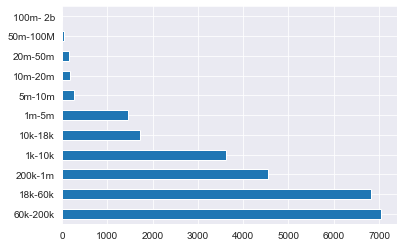

In [61]:
D2['Value'].value_counts(ascending=False).plot.barh();


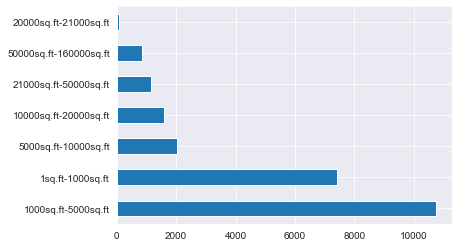

In [62]:
D2['Area'].value_counts(ascending=False).plot.barh();

Investigate Construction See if there is a change in the types of buildings bieng constructed
See the frequency of a specofoc area

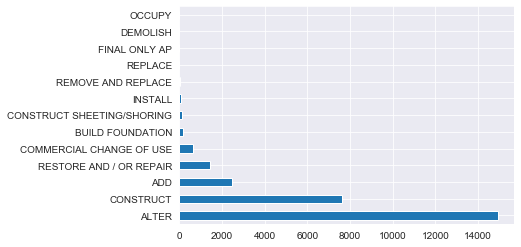

In [63]:
D2['W_type'].value_counts().plot.barh();

Sorting and filtering the type of work in a permit to see what the values are

In [64]:
D6 = D2.loc[(D2.W_type == 'ALTER' )]
D7 = D2.loc[(D2.W_type == 'CONSTRUCT' )]
D8 = D2.loc[(D2.W_type == 'ADD' )]
D9 = D2.loc[(D2.W_type == 'RESTORE AND / OR REPAIR' )]
D10 = D2.loc[(D2.W_type == 'COMMERCIAL CHANGE OF USE' )]


In [67]:
display(D6.Decl_v.sum())
display(D7.Decl_v.sum())
display(D8.Decl_v.sum())
display(D9.Decl_v.sum())
display(D10.Decl_v.sum())

4501448981.35

12385695553.619999

3232686683.51

259411233.79000002

88375911.4

In [68]:
D6.U_code.value_counts(ascending=False).sum()

14928

In [69]:
D6


,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,NewCity,Address,LL,Lat,Lon,Area,Value
7,208716,Finaled,16507,S,FREDERICK,AVE,N/A,GAITHERSBURG,20877,2000-01-03,2000-01-03,2000-01-19,3000.00,10000.00,N/A,ALTER,BUSINESS BUILDING,Gaithersburg,"16507 FREDERICK AVE\nGAITHERSBURG, MD 20877\n","39.127932, -77.18505)",39.127932,-77.18505,1000sq.ft-5000sq.ft,1k-10k
8,208739,Finaled,8600,N/A,OLD GEORGETOWN,RD,N/A,BETHESDA,20817,2000-01-04,2000-01-27,2000-10-31,10350.00,110000.00,"the applicant call on Wednesday, January 12, 2...",ALTER,INSTITUTIONAL BUILDING,Bethesda,"8600 OLD GEORGETOWN RD\nBETHESDA, MD 20817\n","38.997251, -77.10922)",38.997251,-77.10922,10000sq.ft-20000sq.ft,60k-200k
14,208929,Finaled,6831,N/A,WISCONSIN,AVE,N/A,CHEVY CHASE,20815,2000-01-05,2000-01-28,2000-06-05,9430.00,180000.00,all interior work. one storefront door. Per G...,ALTER,MERCANTILE BUILDING,Chevy Chase,"6831 WISCONSIN AVE\nCHEVY CHASE, MD 20815\n","38.978176, -77.091106)",38.978176,-77.091106,5000sq.ft-10000sq.ft,60k-200k
19,209053,Finaled,9910,N/A,BELWARD CAMPUS,DR,N/A,ROCKVILLE,20850,2000-01-06,2000-02-02,2000-10-05,43689.00,10366000.00,revisions to permit number 9908040072,ALTER,BUSINESS BUILDING,Rockville,"9910 BELWARD CAMPUS DR\nROCKVILLE, MD 20850\n","39.103986, -77.209925)",39.103986,-77.209925,21000sq.ft-50000sq.ft,10m-20m
20,209077,Finaled,13121,N/A,WISTERIA,DR,N/A,GERMANTOWN,20874,2000-01-07,2000-01-27,2000-03-03,1695.00,19000.00,N/A,ALTER,BUSINESS BUILDING,Germantown,"13121 WISTERIA DR\nGERMANTOWN, MD 20874\n","39.178984, -77.273584)",39.178984,-77.273584,1000sq.ft-5000sq.ft,18k-60k
22,209104,Finaled,9669,N/A,LOST KNIFE,RD,N/A,MONTGOMERY VILLAGE,20886,2000-01-07,2000-02-10,2000-03-22,3576.00,4000.00,CHANGE OF USE,ALTER,EDUCATIONAL BUILDING,Montgomery Village,"9669 LOST KNIFE RD\nMONTGOMERY VILLAGE, MD 208...","39.154479, -77.200492)",39.154479,-77.200492,1000sq.ft-5000sq.ft,1k-10k
26,209433,Finaled,7851,N/A,BEECHCRAFT,AVE,N/A,GAITHERSBURG,20879,2000-01-12,2000-03-16,2001-03-16,3200.00,100000.00,M-2000-242/DATA DESIGN CORP.,ALTER,BUSINESS BUILDING,Gaithersburg,"7851 BEECHCRAFT AVE\nGAITHERSBURG, MD 20879\n","39.162783, -77.161154)",39.162783,-77.161154,1000sq.ft-5000sq.ft,60k-200k
32,209599,Issued,8120,N/A,WOODMONT,AVE,N/A,BETHESDA,20814,2000-01-13,2000-04-04,NaT,10.00,810595.00,N/A,ALTER,BUSINESS BUILDING,Bethesda,"8120 WOODMONT AVE\nBETHESDA, MD 20814\n","38.991447, -77.096749)",38.991447,-77.096749,1sq.ft-1000sq.ft,200k-1m
34,209660,Finaled,2,N/A,BETHESDA METRO,CTR,N/A,BETHESDA,20814,2000-01-14,2000-02-02,2000-05-03,3247.00,300000.00,"7th floor. This is an over time plan, pl...",ALTER,BUSINESS BUILDING,Bethesda,"2 BETHESDA METRO CTR\nBETHESDA, MD 20814\n","38.984073, -77.095624)",38.984073,-77.095624,1000sq.ft-5000sq.ft,200k-1m
37,209686,Finaled,19801,N/A,CENTURY,BLVD,N/A,GERMANTOWN,20874,2000-01-14,2000-02-10,2000-05-15,272.00,30000.00,N/A,ALTER,BUSINESS BUILDING,Germantown,"19801 CENTURY BLVD\nGERMANTOWN, MD 20874\n","39.180528, -77.267934)",39.180528,-77.267934,1sq.ft-1000sq.ft,18k-60k


“ePlans” is a web-based application that facilitates electronic plan submission and review that
has been tailored to meet the Montgomery County Department of Permitting Services’ (DPS)
processes using ProjectDox software. ePlans allows drawings and documents to be submitted
and reviewed electronically, improves the plan review cycle, and reduces costs associated with
obtaining permits as well as supporting green initiatives

In [70]:
T1 = D2.loc[(D2.Desc.str.contains("ePlans", case=False))]
T1
# so 3375 rows

,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,NewCity,Address,LL,Lat,Lon,Area,Value
19534,695623,Open,7101,N/A,DEMOCRACY,BLVD,N/A,BETHESDA,20817,2014-11-24,NaT,NaT,1500.00,50000.00,ePlans test permits,ADD,BUSINESS BUILDING,Bethesda,"7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n","39.0242, -77.1459)",39.0242,-77.1459,1000sq.ft-5000sq.ft,18k-60k
19535,695624,Open,7101,N/A,DEMOCRACY,BLVD,N/A,BETHESDA,20817,2014-11-24,NaT,NaT,1500.00,50000.00,ePlans test permits,ADD,BUSINESS BUILDING,Bethesda,"7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n","39.0242, -77.1459)",39.0242,-77.1459,1000sq.ft-5000sq.ft,18k-60k
19536,695625,Open,7101,N/A,DEMOCRACY,BLVD,N/A,BETHESDA,20817,2014-11-24,NaT,NaT,1500.00,50000.00,ePlans test permits,ADD,BUSINESS BUILDING,Bethesda,"7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n","39.0242, -77.1459)",39.0242,-77.1459,1000sq.ft-5000sq.ft,18k-60k
19537,695626,Open,7101,N/A,DEMOCRACY,BLVD,N/A,BETHESDA,20817,2014-11-24,NaT,NaT,1500.00,50000.00,ePlans test permits,ADD,BUSINESS BUILDING,Bethesda,"7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n","39.0242, -77.1459)",39.0242,-77.1459,1000sq.ft-5000sq.ft,18k-60k
19551,695706,Finaled,16624,N/A,CRABBS BRANCH,WAY,N/A,ROCKVILLE,20855,2014-11-24,2014-12-29,2015-09-09,500.00,50000.00,Installation of three (3) outside CNG fueling ...,CONSTRUCT,COMMERCIAL MISCELLANEOUS STRUC,Derwood,"16624 CRABBS BRANCH WAY\nROCKVILLE, MD 20855\n","39.126958, -77.166399)",39.126958,-77.166399,1sq.ft-1000sq.ft,18k-60k
19611,695850,Open,7101,N/A,DEMOCRACY,BLVD,N/A,BETHESDA,20817,2014-11-25,NaT,NaT,5000.00,50000.00,ePlans Test Permit,ALTER,BUSINESS BUILDING,Bethesda,"7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n","39.0242, -77.1459)",39.0242,-77.1459,1000sq.ft-5000sq.ft,18k-60k
19612,695851,Open,7101,N/A,DEMOCRACY,BLVD,N/A,BETHESDA,20817,2014-11-25,NaT,NaT,5000.00,50000.00,ePlans Test Permit,ALTER,BUSINESS BUILDING,Bethesda,"7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n","39.0242, -77.1459)",39.0242,-77.1459,1000sq.ft-5000sq.ft,18k-60k
19613,695852,Open,7101,N/A,DEMOCRACY,BLVD,N/A,BETHESDA,20817,2014-11-25,NaT,NaT,5000.00,50000.00,ePlans Test Permit,ALTER,BUSINESS BUILDING,Bethesda,"7101 DEMOCRACY BLVD\nBETHESDA, MD 20817\n","39.0242, -77.1459)",39.0242,-77.1459,1000sq.ft-5000sq.ft,18k-60k
19707,698505,Finaled,8930,N/A,BROOKVILLE,RD,N/A,SILVER SPRING,20910,2014-12-22,2015-02-03,2015-03-10,0.00,5000.00,New Tenant Alteration in existing space &amp; ...,ALTER,BUSINESS BUILDING,Silver Spring,"8930 BROOKVILLE RD\nSILVER SPRING, MD 20910\n","39.003017, -77.052556)",39.003017,-77.052556,NaN,1k-10k
19775,700967,Finaled,19300,N/A,GERMANTOWN,RD,N/A,GERMANTOWN,20874,2015-01-16,2015-03-17,2015-05-19,8619.00,350000.00,Interior alteration to Level 1S&nbsp; - Office...,ALTER,BIOSCIENCE,Germantown,"19300 GERMANTOWN RD\nGERMANTOWN, MD 20874\n","39.173739, -77.274497)",39.173739,-77.274497,5000sq.ft-10000sq.ft,200k-1m


In [71]:
#See how many contain revsion
T2 = D2.loc[(D2.Desc.str.contains("revision", case=False))]
T2.W_type.value_counts() 
# 3636 About 14 percent


ALTER                         2481
CONSTRUCT                      767
ADD                            190
COMMERCIAL CHANGE OF USE       102
RESTORE AND / OR REPAIR         54
CONSTRUCT SHEETING/SHORING      21
BUILD FOUNDATION                17
INSTALL                          3
REMOVE AND REPLACE               1
Name: W_type, dtype: int64

# Visulaztion

In [72]:
Construction = D2.groupby

In [73]:
#sns.catplot(x="Status", kind="count", palette="ch:.25", data=D2);

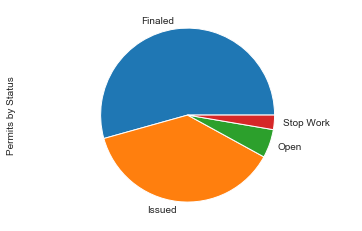

In [74]:
permits_by_status = D2.groupby(D2['Status']).size()
plt.axis('equal') 
permits_by_status.plot(kind='pie', legend=False, label='Permits by Status');

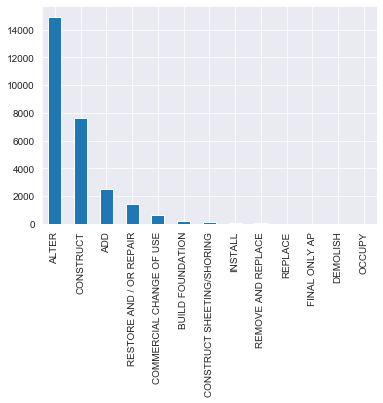

In [75]:
D2['W_type'].value_counts().plot.bar();

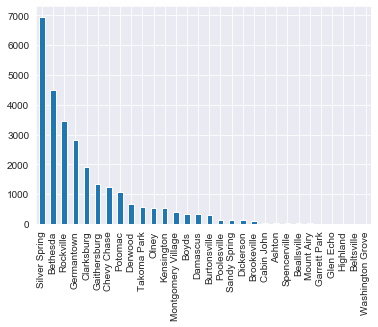

In [77]:
D2['NewCity'].value_counts().plot.bar();

Wait Time

The department of permiting Issue 79.4 days as the Average:
https://stat.montgomerycountymd.gov/stories/s/Department-of-Permitting-Services-DPS-/qaet-mgd9
null 79 

In [78]:
D3 = D2.assign(wait_time = (D2['I_date'] - D2['A_date']).dt.days)
D3

,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,NewCity,Address,LL,Lat,Lon,Area,Value,wait_time
0,208677,Finaled,19850,N/A,CENTURY,BLVD,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-10,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"19850 CENTURY BLVD\nGERMANTOWN, MD 20874\n","39.181866, -77.26558)",39.181866,-77.26558,21000sq.ft-50000sq.ft,200k-1m,346.0
1,208678,Finaled,12901,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-11,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12901 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182081, -77.265196)",39.182081,-77.265196,21000sq.ft-50000sq.ft,200k-1m,346.0
2,208679,Finaled,12903,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-12,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12903 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182361, -77.265512)",39.182361,-77.265512,21000sq.ft-50000sq.ft,200k-1m,346.0
3,208689,Finaled,12907,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-31,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12907 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182922, -77.266143)",39.182922,-77.266143,50000sq.ft-160000sq.ft,1m-5m,346.0
4,208690,Finaled,12909,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-29,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12909 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183215, -77.266444)",39.183215,-77.266444,50000sq.ft-160000sq.ft,1m-5m,346.0
5,208691,Finaled,12925,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-25,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12925 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183411, -77.266188)",39.183411,-77.266188,50000sq.ft-160000sq.ft,1m-5m,346.0
6,208692,Issued,12935,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,NaT,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12935 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.18353, -77.265984)",39.18353,-77.265984,50000sq.ft-160000sq.ft,1m-5m,346.0
7,208716,Finaled,16507,S,FREDERICK,AVE,N/A,GAITHERSBURG,20877,2000-01-03,2000-01-03,2000-01-19,3000.0,10000.00,N/A,ALTER,BUSINESS BUILDING,Gaithersburg,"16507 FREDERICK AVE\nGAITHERSBURG, MD 20877\n","39.127932, -77.18505)",39.127932,-77.18505,1000sq.ft-5000sq.ft,1k-10k,0.0
8,208739,Finaled,8600,N/A,OLD GEORGETOWN,RD,N/A,BETHESDA,20817,2000-01-04,2000-01-27,2000-10-31,10350.0,110000.00,"the applicant call on Wednesday, January 12, 2...",ALTER,INSTITUTIONAL BUILDING,Bethesda,"8600 OLD GEORGETOWN RD\nBETHESDA, MD 20817\n","38.997251, -77.10922)",38.997251,-77.10922,10000sq.ft-20000sq.ft,60k-200k,23.0
9,208772,Finaled,12955,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-04,2000-12-14,2001-12-21,36400.0,750000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12955 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.18377, -77.265575)",39.18377,-77.265575,21000sq.ft-50000sq.ft,200k-1m,345.0


In [79]:
D3['month'] = D3['A_date'].dt.month
D3['year'] = D3['A_date'].dt.year

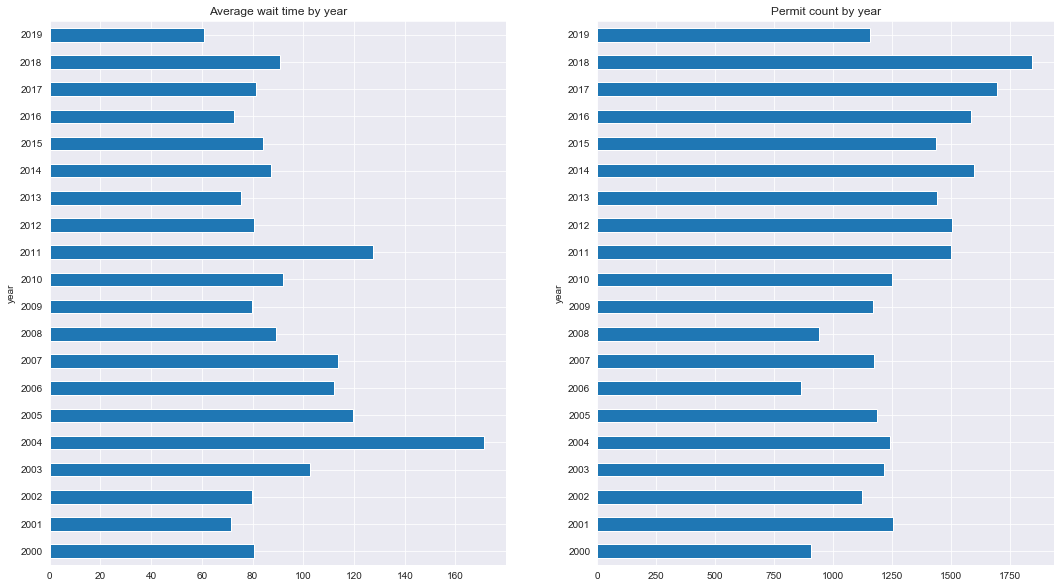

In [80]:
_ = plt.figure(figsize=(18,10))
_ = plt.subplot(1,2,1)
_ = (D3.groupby('year').wait_time.mean()).plot.barh()
_ = plt.title('Average wait time by year')
_ = plt.subplot(1,2,2)
_ = (D3.groupby('year').wait_time.count()).plot.barh()
_ = plt.title('Permit count by year')
#Write a result

In [81]:
(D3.groupby('year').wait_time.mean())


year
2000     80.411894
2001     71.707337
2002     79.648841
2003    102.808230
2004    171.385852
2005    119.729798
2006    112.147161
2007    113.519558
2008     89.181915
2009     79.608027
2010     91.859200
2011    127.611851
2012     80.542497
2013     75.584200
2014     87.104506
2015     84.302293
2016     72.584227
2017     81.320165
2018     90.871073
2019     60.782872
Name: wait_time, dtype: float64

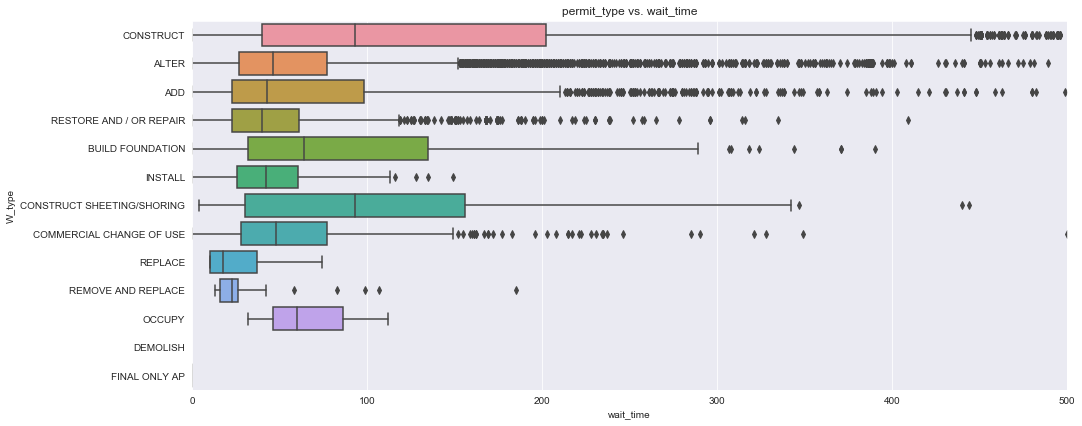

In [82]:
_ = plt.figure(figsize=(15,6))
ax = sns.boxplot(y='W_type', x='wait_time', data = D3, orient = 'h');
plt.title('permit_type vs. wait_time');
plt.tight_layout(pad=1)
plt.xlim(0, 500)
plt.show()


Conclusion: The longest wait time is Construction followed by Alterations. While Alterations have the greatest percentage in this data set Construction beats out Alteration in terms of "Wait Time"

In [84]:
D3

,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,NewCity,Address,LL,Lat,Lon,Area,Value,wait_time,month,year
0,208677,Finaled,19850,N/A,CENTURY,BLVD,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-10,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"19850 CENTURY BLVD\nGERMANTOWN, MD 20874\n","39.181866, -77.26558)",39.181866,-77.26558,21000sq.ft-50000sq.ft,200k-1m,346.0,1,2000
1,208678,Finaled,12901,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-11,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12901 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182081, -77.265196)",39.182081,-77.265196,21000sq.ft-50000sq.ft,200k-1m,346.0,1,2000
2,208679,Finaled,12903,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-12,42600.0,1000000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12903 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182361, -77.265512)",39.182361,-77.265512,21000sq.ft-50000sq.ft,200k-1m,346.0,1,2000
3,208689,Finaled,12907,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-31,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12907 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182922, -77.266143)",39.182922,-77.266143,50000sq.ft-160000sq.ft,1m-5m,346.0,1,2000
4,208690,Finaled,12909,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-29,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12909 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183215, -77.266444)",39.183215,-77.266444,50000sq.ft-160000sq.ft,1m-5m,346.0,1,2000
5,208691,Finaled,12925,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-25,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12925 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183411, -77.266188)",39.183411,-77.266188,50000sq.ft-160000sq.ft,1m-5m,346.0,1,2000
6,208692,Issued,12935,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,NaT,63300.0,1500000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12935 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.18353, -77.265984)",39.18353,-77.265984,50000sq.ft-160000sq.ft,1m-5m,346.0,1,2000
7,208716,Finaled,16507,S,FREDERICK,AVE,N/A,GAITHERSBURG,20877,2000-01-03,2000-01-03,2000-01-19,3000.0,10000.00,N/A,ALTER,BUSINESS BUILDING,Gaithersburg,"16507 FREDERICK AVE\nGAITHERSBURG, MD 20877\n","39.127932, -77.18505)",39.127932,-77.18505,1000sq.ft-5000sq.ft,1k-10k,0.0,1,2000
8,208739,Finaled,8600,N/A,OLD GEORGETOWN,RD,N/A,BETHESDA,20817,2000-01-04,2000-01-27,2000-10-31,10350.0,110000.00,"the applicant call on Wednesday, January 12, 2...",ALTER,INSTITUTIONAL BUILDING,Bethesda,"8600 OLD GEORGETOWN RD\nBETHESDA, MD 20817\n","38.997251, -77.10922)",38.997251,-77.10922,10000sq.ft-20000sq.ft,60k-200k,23.0,1,2000
9,208772,Finaled,12955,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-04,2000-12-14,2001-12-21,36400.0,750000.00,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12955 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.18377, -77.265575)",39.18377,-77.265575,21000sq.ft-50000sq.ft,200k-1m,345.0,1,2000


In [85]:
D3['year'], D3['month'], D3['day_of_week'] = D3.A_date.dt.year, D3.A_date.dt.month, D3.A_date.dt.dayofweek

Select this year and this year

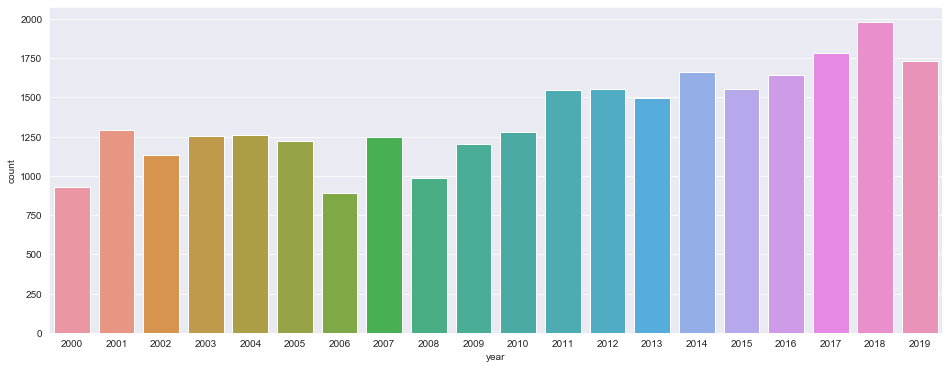

In [86]:
plt.figure(figsize=(16, 6))
sns.countplot(x="year", data=D3);

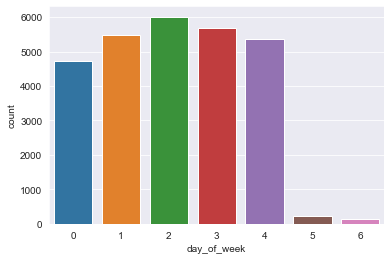

In [87]:
sns.countplot(x="day_of_week", data=D3);

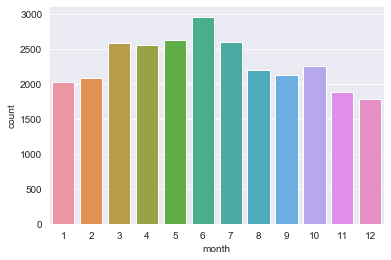

In [88]:
sns.countplot(x="month", data=D3);
#most permits were filed in the summer

Conclusion: The majority of permits are submitted on Sunday through Thursday

In [89]:
D3.groupby('year').P_num.count()

year
2000     926
2001    1289
2002    1134
2003    1256
2004    1258
2005    1220
2006     892
2007    1249
2008     989
2009    1202
2010    1279
2011    1546
2012    1554
2013    1493
2014    1663
2015    1554
2016    1641
2017    1780
2018    1979
2019    1729
Name: P_num, dtype: int64

In [90]:
DTime = D3.set_index('A_date')
T4 = D3.loc[(D2.Desc.str.contains("solar panel", case=False))]
DTime1 = T4.set_index('A_date')

What caused the big spike in 2011 and 2004.

In [91]:
permits_by_type = D2.groupby(['U_code']).size()
permits_by_type.sort_values(ascending=False, inplace=True)
permits_by_type.head(5)

U_code
BUSINESS BUILDING                 6926
MULTI-FAMILY DWELLING             4571
COMMERCIAL MISCELLANEOUS STRUC    2840
MERCANTILE BUILDING               2255
TOWNHOUSE                         1688
dtype: int64

In [92]:
filtered_permits = list(permits_by_type.head(5).index)
filtered_permits

['BUSINESS BUILDING',
 'MULTI-FAMILY DWELLING',
 'COMMERCIAL MISCELLANEOUS STRUC',
 'MERCANTILE BUILDING',
 'TOWNHOUSE']

In [93]:
filtered_df = D2.loc[D2['U_code'].isin(filtered_permits)]
filtered_df.head()


,P_num,Status,St_num,Pre_d,St_name,St_suf,Post_d,City,Zip,A_date,I_date,F_date,Building_area,Decl_v,Desc,W_type,U_code,NewCity,Address,LL,Lat,Lon,Area,Value
0,208677,Finaled,19850,N/A,CENTURY,BLVD,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-10,42600.0,1000000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"19850 CENTURY BLVD\nGERMANTOWN, MD 20874\n","39.181866, -77.26558)",39.181866,-77.26558,21000sq.ft-50000sq.ft,200k-1m
1,208678,Finaled,12901,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-11,42600.0,1000000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12901 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182081, -77.265196)",39.182081,-77.265196,21000sq.ft-50000sq.ft,200k-1m
2,208679,Finaled,12903,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2001-10-12,42600.0,1000000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12903 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182361, -77.265512)",39.182361,-77.265512,21000sq.ft-50000sq.ft,200k-1m
3,208689,Finaled,12907,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-31,63300.0,1500000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12907 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.182922, -77.266143)",39.182922,-77.266143,50000sq.ft-160000sq.ft,1m-5m
4,208690,Finaled,12909,N/A,PINNACLE,DR,N/A,GERMANTOWN,20874,2000-01-03,2000-12-14,2002-01-29,63300.0,1500000.0,N/A,CONSTRUCT,MULTI-FAMILY DWELLING,Germantown,"12909 PINNACLE DR\nGERMANTOWN, MD 20874\n","39.183215, -77.266444)",39.183215,-77.266444,50000sq.ft-160000sq.ft,1m-5m


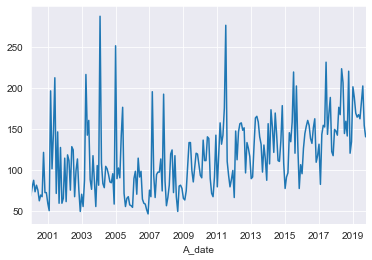

In [94]:
DTime['num'] = 1
DTime['num'].resample('M').sum().plot();

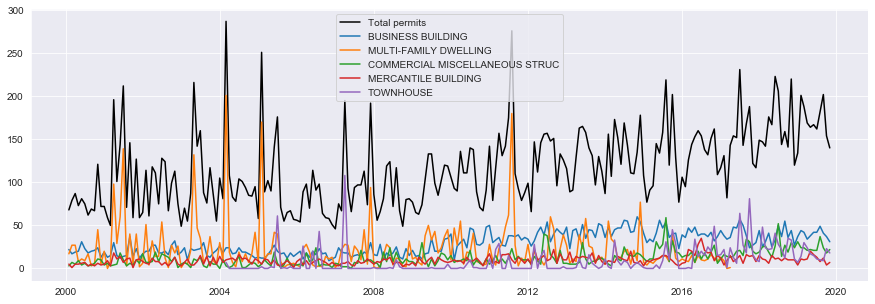

In [95]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(DTime['num'].resample('M').sum(), 'k', label='Total permits')
for use_code in filtered_permits:
    x = DTime[DTime.U_code == use_code]['num'].resample('M').sum()
    ax.plot(x, label=use_code)
ax.legend();

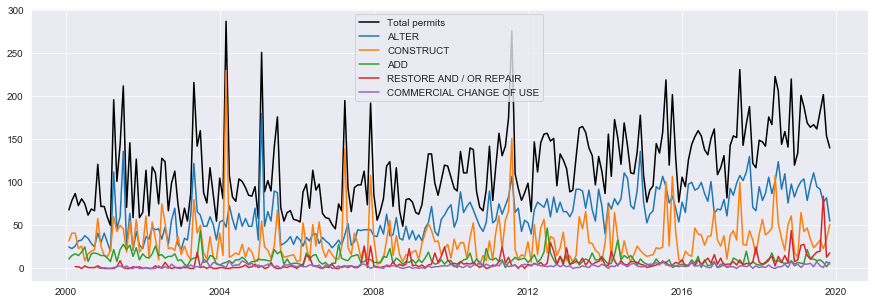

In [96]:
permits_by_type1 = D2.groupby(['W_type']).size()
permits_by_type1.sort_values(ascending=False, inplace=True)
permits_by_type1.head(5)
filtered_permits1 = list(permits_by_type1.head(5).index)
filtered_permits1
filtered_df1 = D2.loc[D2['W_type'].isin(filtered_permits1)]
filtered_df1.head()
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1)

ax.plot(DTime['num'].resample('M').sum(), 'k', label='Total permits')
for work in filtered_permits1:
    x = DTime[DTime.W_type == work]['num'].resample('M').sum()
    ax.plot(x, label=work)
ax.legend();

The greatest spike was in construction and in the multi-family housing projects.

In [96]:
D3.to_csv('D3',index=False)

In [97]:
Ir = D3.loc[D3.I_date.isnull()]
Ir.year.value_counts().sum()
# Most are in 2019 and 2018 706 out of 1532

1531

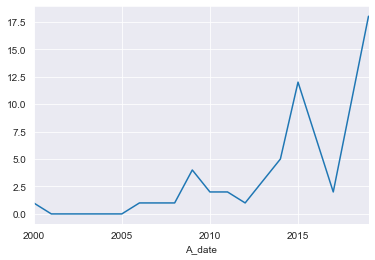

In [98]:
# Resampleing by year
DTime1['num'] = 1
DTime1['num'].resample('y').sum().plot();

# MAPS

Goals:
1. To show the distribution of permits
2. To show a change in the the types of permits done 
3. Showing a map of open permits 
4. Showing a map of "finalled"
5. Show map with type of construction 
6. Make a heat map
7. Compare two different years 
8. Show Solar panels
9. Show a map by highest value
 

Link to Maps
https://public.tableau.com/profile/abraham.lewis#!/vizhome/Book1_15754944071890/Sheet3
https://public.tableau.com/profile/abraham.lewis#!/vizhome/Book1_15754944071890/Sheet4
https://public.tableau.com/profile/abraham.lewis#!/vizhome/Book1_15754944071890/Sheet5
https://public.tableau.com/profile/abraham.lewis#!/vizhome/Book1_15754944071890/Sheet6

 # Statistical analysis

1. Using Anova for Value and New City
2. Show the correlation between Area and Work Type.
3. Show the correlation between Value and Use code.
4. Using a T-test for the Mean Value

Seeing if there is a connection between work type and valuation


In [100]:
CH = filtered_df[['U_code', 'Value']]
CH.head()

,U_code,Value
0,MULTI-FAMILY DWELLING,200k-1m
1,MULTI-FAMILY DWELLING,200k-1m
2,MULTI-FAMILY DWELLING,200k-1m
3,MULTI-FAMILY DWELLING,1m-5m
4,MULTI-FAMILY DWELLING,1m-5m


In [101]:
CH['U_code'].value_counts()
# Total permits 18280 about 67 percent of all permits so a good represntation 

BUSINESS BUILDING                 6926
MULTI-FAMILY DWELLING             4571
COMMERCIAL MISCELLANEOUS STRUC    2840
MERCANTILE BUILDING               2255
TOWNHOUSE                         1688
Name: U_code, dtype: int64

H0:There is no statistically significant relationship between the Use code and the value of of a permit.
Ha:There is a statistically significant relationship between the Use code and the value of a permit.

In [102]:
contingency_table = pd.crosstab(
    CH['U_code'],
    CH['Value'],
    margins = False
)
contingency_table

Value,1k-10k,10k-18k,18k-60k,60k-200k,200k-1m,1m-5m,5m-10m,10m-20m,20m-50m,50m-100M,100m- 2b
U_code,,,,,,,,,,,
BUSINESS BUILDING,630,451,1761,1755,1482,389,60,40,24,6,1
COMMERCIAL MISCELLANEOUS STRUC,771,419,1025,296,147,41,2,4,3,0,0
MERCANTILE BUILDING,280,118,531,609,421,122,13,8,6,1,1
MULTI-FAMILY DWELLING,597,164,1058,1301,536,289,34,27,36,12,0
TOWNHOUSE,95,22,30,994,529,7,0,0,0,0,0


In [103]:

from scipy import stats
stats.chi2_contingency(contingency_table)

(3241.969701275461,
 0.0,
 40,
 array([[9.13192617e+02, 4.51785981e+02, 1.69515949e+03, 1.90681391e+03,
         1.19873367e+03, 3.26332634e+02, 4.19460578e+01, 3.04012713e+01,
         2.65530091e+01, 7.31169816e+00, 7.69652438e-01],
        [3.74742477e+02, 1.85397247e+02, 6.95634476e+02, 7.82490086e+02,
         4.91918591e+02, 1.33915559e+02, 1.72132027e+01, 1.24756240e+01,
         1.08964311e+01, 3.00046653e+00, 3.15838582e-01],
        [2.91989153e+02, 1.44456496e+02, 5.42019477e+02, 6.09695008e+02,
         3.83289596e+02, 1.04343364e+02, 1.34120597e+01, 9.72066713e+00,
         8.49020294e+00, 2.33788197e+00, 2.46092839e-01],
        [5.61006648e+02, 2.77548169e+02, 1.04139666e+03, 1.17142349e+03,
         7.36424656e+02, 2.00477723e+02, 2.57689526e+01, 1.86765804e+01,
         1.63124563e+01, 4.49183578e+00, 4.72824819e-01],
        [2.32069104e+02, 1.14812106e+02, 4.30789888e+02, 4.84577502e+02,
         3.04633485e+02, 8.29307208e+01, 1.06597271e+01, 7.72585724e+00,
       

H0:There is no statistically significant relationship between the Work type and the Area of of a permit.
Ha:There is a statistically significant relationship between the Work type and the Area of a permit.

In [104]:
permits_by_w = D2.groupby(['W_type']).size()
permits_by_w.sort_values(ascending=False, inplace=True)
filtered_permits1 = list(permits_by_w.head(4).index)
filtered_permits1
filtered_df1 = D2.loc[D2['W_type'].isin(filtered_permits1)]
permits_by_w.head(4)
AC = filtered_df1[['W_type', 'Area']]
AC['W_type'].value_counts()

ALTER                      14928
CONSTRUCT                   7625
ADD                         2495
RESTORE AND / OR REPAIR     1454
Name: W_type, dtype: int64

In [105]:
contingency_table1 = pd.crosstab(
    AC['W_type'],
    AC['Area'],
    margins = False
)
contingency_table1

Area,1sq.ft-1000sq.ft,1000sq.ft-5000sq.ft,5000sq.ft-10000sq.ft,10000sq.ft-20000sq.ft,20000sq.ft-21000sq.ft,21000sq.ft-50000sq.ft,50000sq.ft-160000sq.ft
W_type,,,,,,,
ADD,1245,435,110,73,5,84,55
ALTER,3634,5461,1386,1058,43,694,395
CONSTRUCT,1717,4079,334,362,18,269,298
RESTORE AND / OR REPAIR,591,303,96,52,6,51,51


In [106]:
stats.chi2_contingency(contingency_table1)

(1884.2908909162288,
 0.0,
 18,
 array([[6.29744990e+02, 9.00587033e+02, 1.68761493e+02, 1.35377210e+02,
         6.30884086e+00, 9.62098232e+01, 7.00106090e+01],
        [3.97583397e+03, 5.68576896e+03, 1.06545933e+03, 8.54690897e+02,
         3.98302554e+01, 6.07411395e+02, 4.42005195e+02],
        [2.22058062e+03, 3.17561257e+03, 5.95079764e+02, 4.77361493e+02,
         2.22459725e+01, 3.39251081e+02, 2.46868500e+02],
        [3.60840428e+02, 5.16031434e+02, 9.66994106e+01, 7.75703995e+01,
         3.61493124e+00, 5.51277014e+01, 4.01156953e+01]]))

In the first example I am doing a Chi-Square test comparing the the bins of Value with Use code.
* The Chi Statistic - 3241.969701275461, the P_vale is 0.0 so less than .05 therefore we reject the null hypothesis that there is no difference between the mean and we conclude that there is a connection between a permits value and its Use code.
* 40 - the degrees of freedom
In the Second example I did another Chi-Square test comparing the the bins of Area with Work Type.
* The Chi Statistic -1884.2908909162288 , the P_vale is 0.0 so less than .05 therefore we reject the null hypothesis that there is no difference between the mean and we conclude that there is a connection between the Area of a permit and the Work Type.
* 18 - the degrees of freedom



In [107]:
DA = pd.read_csv('data.csv')
DA
#DA.PopTotal.sum()
list(D2.columns) 

['P_num',
 'Status',
 'St_num',
 'Pre_d',
 'St_name',
 'St_suf',
 'Post_d',
 'City',
 'Zip',
 'A_date',
 'I_date',
 'F_date',
 'Building_area',
 'Decl_v',
 'Desc',
 'W_type',
 'U_code',
 'NewCity',
 'Address',
 'LL',
 'Lat',
 'Lon',
 'Area',
 'Value']

In [108]:
list(D2.columns) 
D4 = D2.reindex(columns=['P_num','Status','St_num','Pre_d','St_name','St_suf','Post_d','City','Zip','A_date','I_date',
'F_date','Building_area','Decl_v','Desc','W_type','U_code','NewCity','Address','LL','Lat','Lon','Value'])
df_anova = D4[['Decl_v','NewCity']]
grps = pd.unique(df_anova.Decl_v.values)

ANOVA In this example example is being used in order to test whether Value of the permits differs based on some categorical variable like City, we have to compare the means of each level or group the variable. The analysis here is one of variance as ANOVA is a statistical inference test that lets you compare multiple groups at the same time.
F = Between group variability / Within group variability
There are 3 different Cities and their Values and here I am checking whether all 3 group are similar or not. 

In [121]:
# I got Anova to work and right before I uploaded it it stopped working 
# I tried to fix it with and exception statement but it didnt work
#from scipy import stats
#from statsmodels.stats import weightstats as stests
#df_anova = D4[['Decl_v','NewCity']]
#grps = pd.unique(df_anova.NewCity.values)
#d_data = {grp:df_anova['Decl_v'][df_anova.NewCity == grp] for grp in grps}
#try:
    #F, p = stats.f_oneway(D4.loc[(D4.NewCity == 'Rockville')], D4.loc[(D4.NewCity=='Silver Spring')], D4.loc[D4.NewCity == 'Bethesda'])
#except ValueError:
    #print("p-value for significance is: ", p)
#if np.all(p<0.05):
    #print("reject null hypothesis")
#else:
    #print("accept null hypothesis")


We accept the null hypothesis that the 3 are similar.

In [122]:
#checking the Mean for Decl_v
from scipy.stats import ttest_1samp
Val = D2['Decl_v']
Val_mean = np.mean(Val)
print(Val_mean)
tset, pval = ttest_1samp(Val, 50000)
print(pval)
if pval < 0.05:    # alpha value is 0.05 or 5%
   print(" we reject the  null hypothesis")
else:
  print("we accept the null hypothesis")

761652.7176296487
5.802495665200189e-47
 we reject the  null hypothesis


We reject the null hypothesis of 50000 being the mean.

In [123]:
City = D4['NewCity'].value_counts().head()


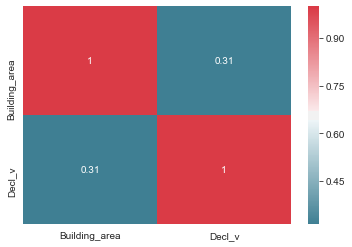

In [124]:
corr = D2.loc[:,D2.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True));
# scatter plot line best fit

Going through sums of different cites and work types in the county

In [128]:
D2S = D2.loc[D2.NewCity == 'Silver Spring' ]
D2B = D2.loc[D2.NewCity == 'Bethesda' ]
D2R = D2.loc[D2.NewCity == 'Rockville' ]
D2G = D2.loc[D2.NewCity == 'Germantown']
D2C = D2.loc[D2.NewCity == 'Clarksburg' ]

In [129]:
display(D2S['P_num'].value_counts().sum())
display(D2B['P_num'].value_counts().sum())
display(D2R['P_num'].value_counts().sum())
display(D2G['P_num'].value_counts().sum())
display(D2C['P_num'].value_counts().sum())
#19656 72% 0f all permits


6954

4513

3471

2802

1916

In [130]:
D2.P_num = D2.P_num.astype(str)
display(D2S['Decl_v'].sum())
display(D2B['Decl_v'].sum())
display(D2R['Decl_v'].sum())
display(D2G['Decl_v'].sum())
display(D2C['Decl_v'].sum())



5324379340.01

3756550714.2400002

5374386392.95

1722628345.3

459812873.35

In [131]:
display(D2S['W_type'].value_counts())
display(D2B['W_type'].value_counts())
display(D2R['W_type'].value_counts())
display(D2G['W_type'].value_counts())
display(D2C['W_type'].value_counts())

ALTER                         4064
CONSTRUCT                     1378
ADD                            717
RESTORE AND / OR REPAIR        469
COMMERCIAL CHANGE OF USE       222
BUILD FOUNDATION                44
CONSTRUCT SHEETING/SHORING      32
INSTALL                         24
REMOVE AND REPLACE               2
DEMOLISH                         2
Name: W_type, dtype: int64

ALTER                         2844
CONSTRUCT                      853
ADD                            406
RESTORE AND / OR REPAIR        248
COMMERCIAL CHANGE OF USE        77
CONSTRUCT SHEETING/SHORING      48
BUILD FOUNDATION                24
INSTALL                         12
REPLACE                          1
Name: W_type, dtype: int64

ALTER                         2223
CONSTRUCT                      598
ADD                            272
RESTORE AND / OR REPAIR        219
COMMERCIAL CHANGE OF USE        74
BUILD FOUNDATION                46
CONSTRUCT SHEETING/SHORING      24
INSTALL                          9
REMOVE AND REPLACE               2
FINAL ONLY AP                    2
REPLACE                          2
Name: W_type, dtype: int64

ALTER                       1246
CONSTRUCT                   1124
ADD                          166
RESTORE AND / OR REPAIR      156
COMMERCIAL CHANGE OF USE      48
REMOVE AND REPLACE            38
BUILD FOUNDATION              11
INSTALL                        6
REPLACE                        6
FINAL ONLY AP                  1
Name: W_type, dtype: int64

CONSTRUCT                   1577
ALTER                        250
ADD                           70
RESTORE AND / OR REPAIR        7
BUILD FOUNDATION               6
COMMERCIAL CHANGE OF USE       6
Name: W_type, dtype: int64

In [132]:
display(D2S['U_code'].value_counts())
display(D2B['U_code'].value_counts())
display(D2R['U_code'].value_counts())
display(D2G['U_code'].value_counts())
display(D2C['U_code'].value_counts())

BUSINESS BUILDING                   1519
MULTI-FAMILY DWELLING               1417
COMMERCIAL MISCELLANEOUS STRUC       671
MERCANTILE BUILDING                  644
RESTAURANT                           504
EDUCATIONAL BUILDING                 354
TOWNHOUSE                            349
ASSEMBLY BUILDING                    225
MULTIFAMILY DWELLING LOW RISE        155
PLACE OF WORSHIP                     148
STORAGE BUILDING                      89
RETAINING WALL                        83
HOSPITAL                              80
MISCELLANEOUS STRUCTURE               78
MULTI-FAMILY SENIOR CITIZEN BL        74
BANK                                  60
TRAILER                               57
GARAGE                                54
MULTIFAMILY DWELLING HIGH RISE        50
HOTEL                                 48
INSTITUTIONAL BUILDING                41
BUSINESS                              36
INDUSTRIAL BUILDING                   34
SWIMMING POOL                         27
WIRELESS EQUIPME

BUSINESS BUILDING                   1557
MERCANTILE BUILDING                  430
COMMERCIAL MISCELLANEOUS STRUC       396
RESTAURANT                           318
TOWNHOUSE                            303
MULTI-FAMILY DWELLING                298
EDUCATIONAL BUILDING                 224
ASSEMBLY BUILDING                    198
MULTIFAMILY DWELLING HIGH RISE       111
HOSPITAL                              81
STORAGE BUILDING                      70
GARAGE                                64
BANK                                  51
MULTIFAMILY DWELLING LOW RISE         50
RETAINING WALL                        50
HOTEL                                 48
TRAILER                               44
MISCELLANEOUS STRUCTURE               37
PLACE OF WORSHIP                      35
INSTITUTIONAL BUILDING                30
SWIMMING POOL                         23
MULTI-FAMILY SENIOR CITIZEN BL        12
MERCANTILE                            10
BUSINESS                              10
WIRELESS EQUIPME

BUSINESS BUILDING                   1349
MULTI-FAMILY DWELLING                326
MERCANTILE BUILDING                  275
COMMERCIAL MISCELLANEOUS STRUC       265
RESTAURANT                           150
ASSEMBLY BUILDING                    137
EDUCATIONAL BUILDING                 127
BIOSCIENCE                           124
STORAGE BUILDING                     101
HOSPITAL                              77
GARAGE                                57
RETAINING WALL                        50
MULTIFAMILY DWELLING LOW RISE         49
TOWNHOUSE                             43
MISCELLANEOUS STRUCTURE               42
TRAILER                               41
INDUSTRIAL BUILDING                   39
PLACE OF WORSHIP                      26
MULTIFAMILY DWELLING HIGH RISE        24
SWIMMING POOL                         21
BANK                                  20
INSTITUTIONAL BUILDING                19
WIRELESS EQUIPMENT                    13
MULTI-FAMILY SENIOR CITIZEN BL         9
HOTEL           

MULTI-FAMILY DWELLING             785
BUSINESS BUILDING                 568
COMMERCIAL MISCELLANEOUS STRUC    294
TOWNHOUSE                         178
MERCANTILE BUILDING               170
RESTAURANT                        143
EDUCATIONAL BUILDING              130
MULTIFAMILY DWELLING LOW RISE     106
ASSEMBLY BUILDING                  75
RETAINING WALL                     68
STORAGE BUILDING                   40
MISCELLANEOUS STRUCTURE            28
TRAILER                            24
BANK                               23
GARAGE                             22
PLACE OF WORSHIP                   21
INDUSTRIAL BUILDING                21
BIOSCIENCE                         17
SWIMMING POOL                       8
HOSPITAL                            7
MULTI-FAMILY SENIOR CITIZEN BL      7
WIRELESS EQUIPMENT                  6
MULTIFAMILY DWELLING HIGH RISE      6
BUSINESS                            5
FENCE                               5
HOTEL                               5
TOWER       

MULTI-FAMILY DWELLING             916
TOWNHOUSE                         334
MULTIFAMILY DWELLING LOW RISE     155
BUSINESS BUILDING                 121
COMMERCIAL MISCELLANEOUS STRUC    112
RETAINING WALL                     43
EDUCATIONAL BUILDING               38
MERCANTILE BUILDING                36
ASSEMBLY BUILDING                  33
MISCELLANEOUS STRUCTURE            32
STORAGE BUILDING                   24
RESTAURANT                         17
TRAILER                            13
SWIMMING POOL                      12
PLACE OF WORSHIP                    6
GARAGE                              5
SHED                                4
TOWER                               2
BANK                                2
INDUSTRIAL BUILDING                 2
DAY CARE                            1
FACTORY AND INDUST, MOD HAZ         1
MULTI-FAMILY SENIOR CITIZEN BL      1
HOSPITAL                            1
FENCE                               1
FACTORY AND INDUST, LOW HAZ         1
EDUCATIONAL 

In [133]:
D2S1 = D6.loc[D2.NewCity == 'Silver Spring' ]
D2B1 = D6.loc[D2.NewCity == 'Bethesda' ]
D2R1 = D6.loc[D2.NewCity == 'Rockville' ]
D2G1 = D6.loc[D2.NewCity == 'Germantown']
D2C1 = D6.loc[D2.NewCity == 'Clarksburg' ]

In [134]:
display(D2S1['P_num'].value_counts().sum())
display(D2B1['P_num'].value_counts().sum())
display(D2R1['P_num'].value_counts().sum())
display(D2G1['P_num'].value_counts().sum())
display(D2C1['P_num'].value_counts().sum())

4064

2844

2223

1246

250

In [135]:
display(D2S1['U_code'].value_counts())
display(D2B1['U_code'].value_counts())
display(D2R1['U_code'].value_counts())
display(D2G1['U_code'].value_counts())
display(D2C1['U_code'].value_counts())

BUSINESS BUILDING                 1200
MULTI-FAMILY DWELLING              808
MERCANTILE BUILDING                504
RESTAURANT                         401
COMMERCIAL MISCELLANEOUS STRUC     277
EDUCATIONAL BUILDING               163
ASSEMBLY BUILDING                  135
PLACE OF WORSHIP                    70
HOSPITAL                            60
MULTIFAMILY DWELLING LOW RISE       51
BANK                                48
MULTI-FAMILY SENIOR CITIZEN BL      41
STORAGE BUILDING                    38
MISCELLANEOUS STRUCTURE             31
MULTIFAMILY DWELLING HIGH RISE      29
BUSINESS                            28
HOTEL                               26
INSTITUTIONAL BUILDING              25
INDUSTRIAL BUILDING                 23
GARAGE                              18
MERCANTILE                          12
TOWER                               12
SWIMMING POOL                        9
TOWNHOUSE                            9
BIOSCIENCE                           6
ASSEMBLY, RESTAURANTS    

BUSINESS BUILDING                 1289
MERCANTILE BUILDING                373
RESTAURANT                         283
MULTI-FAMILY DWELLING              165
ASSEMBLY BUILDING                  124
COMMERCIAL MISCELLANEOUS STRUC     121
EDUCATIONAL BUILDING               104
HOSPITAL                            73
HOTEL                               44
BANK                                43
MULTIFAMILY DWELLING HIGH RISE      39
STORAGE BUILDING                    29
MULTIFAMILY DWELLING LOW RISE       27
INSTITUTIONAL BUILDING              22
PLACE OF WORSHIP                    20
GARAGE                              13
MISCELLANEOUS STRUCTURE             10
BUSINESS                             8
MULTI-FAMILY SENIOR CITIZEN BL       7
MERCANTILE                           7
TOWNHOUSE                            6
SWIMMING POOL                        6
ASSEMBLY, RESTAURANTS                6
TOWER                                4
RESIDENTIAL, HOTELS                  3
INDUSTRIAL BUILDING      

BUSINESS BUILDING                 1157
MERCANTILE BUILDING                208
RESTAURANT                         127
MULTI-FAMILY DWELLING              105
BIOSCIENCE                         100
ASSEMBLY BUILDING                   85
COMMERCIAL MISCELLANEOUS STRUC      80
HOSPITAL                            69
STORAGE BUILDING                    61
EDUCATIONAL BUILDING                59
INDUSTRIAL BUILDING                 25
INSTITUTIONAL BUILDING              17
PLACE OF WORSHIP                    15
MULTIFAMILY DWELLING HIGH RISE      14
BANK                                10
MULTIFAMILY DWELLING LOW RISE        8
GARAGE                               8
MISCELLANEOUS STRUCTURE              7
BUSINESS                             6
SWIMMING POOL                        6
RETAINING WALL                       5
STORAGE, MODERATE HAZARD             5
TOWER                                5
HOTEL                                5
WIRELESS EQUIPMENT                   4
TOWNHOUSE                

BUSINESS BUILDING                 486
MULTI-FAMILY DWELLING             232
MERCANTILE BUILDING               130
RESTAURANT                        109
COMMERCIAL MISCELLANEOUS STRUC     58
EDUCATIONAL BUILDING               52
ASSEMBLY BUILDING                  41
MULTIFAMILY DWELLING LOW RISE      25
BIOSCIENCE                         16
BANK                               14
STORAGE BUILDING                   12
INDUSTRIAL BUILDING                12
PLACE OF WORSHIP                   11
HOSPITAL                            5
MISCELLANEOUS STRUCTURE             5
BUSINESS                            5
TOWNHOUSE                           5
TOWER                               4
HOTEL                               3
ASSEMBLY, RESTAURANTS               3
MERCANTILE                          3
DAY CARE                            2
RESIDENTIAL, HOTELS                 1
INSTITUTIONAL, RESTRAINED           1
INSTITUTIONAL BUILDING              1
SINGLE FAMILY DWELLING              1
INSTITUTIONA

BUSINESS BUILDING                 90
TOWNHOUSE                         55
ASSEMBLY BUILDING                 17
MULTI-FAMILY DWELLING             16
MERCANTILE BUILDING               15
COMMERCIAL MISCELLANEOUS STRUC    13
RESTAURANT                        13
STORAGE BUILDING                  11
EDUCATIONAL BUILDING               6
MISCELLANEOUS STRUCTURE            3
PLACE OF WORSHIP                   2
BANK                               2
BUSINESS                           1
FACTORY AND INDUST, MOD HAZ        1
INDUSTRIAL BUILDING                1
FACTORY AND INDUST, LOW HAZ        1
RETAINING WALL                     1
SWIMMING POOL                      1
DAY CARE                           1
Name: U_code, dtype: int64

In [136]:
# years where permits were open 
OD = D3.loc[D3.Status == 'Open' ]
display(OD.year.value_counts())
display(OD.W_type.value_counts(normalize=True))
display(OD.U_code.value_counts(normalize=True))


2019    573
2018    133
2015    114
2017     84
2007     73
2014     65
2016     56
2013     51
2012     49
2008     49
2011     42
2003     32
2005     29
2009     29
2006     28
2010     27
2001     14
2004     12
2002      3
2000      1
Name: year, dtype: int64

ALTER                         0.437842
CONSTRUCT                     0.296448
ADD                           0.099727
RESTORE AND / OR REPAIR       0.088798
COMMERCIAL CHANGE OF USE      0.032104
INSTALL                       0.025956
BUILD FOUNDATION              0.008197
CONSTRUCT SHEETING/SHORING    0.004781
FINAL ONLY AP                 0.003415
DEMOLISH                      0.002049
REPLACE                       0.000683
Name: W_type, dtype: float64

BUSINESS BUILDING                   0.230874
COMMERCIAL MISCELLANEOUS STRUC      0.158470
MERCANTILE BUILDING                 0.062842
RESTAURANT                          0.062158
MULTIFAMILY DWELLING LOW RISE       0.057377
MULTI-FAMILY DWELLING               0.056011
ASSEMBLY BUILDING                   0.049863
EDUCATIONAL BUILDING                0.049180
TOWNHOUSE                           0.032104
WIRELESS EQUIPMENT                  0.029372
TRAILER                             0.024590
PLACE OF WORSHIP                    0.023907
STORAGE BUILDING                    0.020492
MULTIFAMILY DWELLING HIGH RISE      0.019809
MISCELLANEOUS STRUCTURE             0.019126
BANK                                0.012295
RETAINING WALL                      0.010246
TOWER                               0.008880
HOSPITAL                            0.008197
SOIL                                0.007514
SHED                                0.006831
BIOSCIENCE                          0.006831
INSTITUTIO

In [137]:
D2['Status'].value_counts(normalize=True)

Finaled      0.543444
Issued       0.376760
Open         0.052980
Stop Work    0.026816
Name: Status, dtype: float64

In [138]:
OS = D3.loc[D3.Status == 'Stop Work' ]
display(OS.W_type.value_counts(normalize=True))
display(OS.U_code.value_counts(normalize=True))
display(OS.year.value_counts(normalize=True))

CONSTRUCT                   0.545209
ADD                         0.272605
ALTER                       0.159244
RESTORE AND / OR REPAIR     0.010796
INSTALL                     0.005398
COMMERCIAL CHANGE OF USE    0.004049
BUILD FOUNDATION            0.002699
Name: W_type, dtype: float64

COMMERCIAL MISCELLANEOUS STRUC    0.252362
EDUCATIONAL BUILDING              0.238866
BUSINESS BUILDING                 0.130904
RETAINING WALL                    0.068826
TRAILER                           0.045884
STORAGE BUILDING                  0.031039
MULTI-FAMILY DWELLING             0.029690
MISCELLANEOUS STRUCTURE           0.028340
MERCANTILE BUILDING               0.025641
PLACE OF WORSHIP                  0.024291
GARAGE                            0.017544
ASSEMBLY BUILDING                 0.017544
RESTAURANT                        0.014845
TOWNHOUSE                         0.013495
SWIMMING POOL                     0.012146
HOSPITAL                          0.008097
MULTIFAMILY DWELLING HIGH RISE    0.005398
WIRELESS EQUIPMENT                0.005398
TOWER                             0.005398
SHED                              0.004049
FENCE                             0.004049
BIOSCIENCE                        0.002699
INDUSTRIAL BUILDING               0.002699
HOTEL      

2013    0.182186
2014    0.147099
2012    0.136302
2018    0.112011
2016    0.112011
2017    0.097166
2015    0.078273
2001    0.031039
2000    0.022942
2019    0.017544
2011    0.014845
2002    0.013495
2003    0.012146
2004    0.008097
2009    0.004049
2005    0.004049
2010    0.004049
2008    0.001350
2006    0.001350
Name: year, dtype: float64

# Conclusions
In this project, I explored permit data for Montgomery County, Maryland. Based on my findings we can conclude the several things.
1. The amount and value of each permit issued in each city.
2. The fact that the county seems to be growing as more and more permits are being issued.
3. There is growing percentage of new multi-family dwellings vs. the amount of single family houses.
4. Mall and hospitals permits have the highest permit density.
5. Most permits are concentrated in the top five cities.
6. Construction and alterations have the longest wait time and make up the majority of permits.
7. The wait time of a permit is similar to what the county claims.
8. Most structures having commercial permits issued for them are Business Buildings and Multi-family Dwellings.
9. Work type and and Area, Use code and value are correlated.
10. Area and Value and Value are correlated